# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install phik -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import phik

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler,
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import  KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

Данные представленны в 1-ом файле, прочитаем его и сохраним

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/csv/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
# df = pd.read_csv('/datasets/autos.csv')
# df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных у нас имеется: 9 колонок типа object, 7 колонок типа int, 354369 строк

### Предобработка данных

In [ ]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Наблюдаем пропуски в данных, заполнение постараемся реализовать внутри пайплайна

Проверим уникальные значения категориальных переменных:

In [ ]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
[_ for _ in df['RegistrationYear'].unique() if _ > 2021]

[5000,
 9999,
 3200,
 8888,
 2200,
 4100,
 3000,
 2066,
 8000,
 5300,
 9000,
 2900,
 6000,
 5900,
 5911,
 4000,
 8500,
 3700,
 3800,
 4800,
 7000,
 6500,
 2290,
 2500,
 9450,
 2800,
 5555,
 5600,
 2222,
 9996,
 8455,
 4500,
 7800,
 9229,
 7100,
 8200,
 7500,
 3500]

Есть значения год регистрации автомобиля больше текущего года, что не может быть истинной чисто логически

In [ ]:
len(df[df['RegistrationYear'] > 2021])

105

In [ ]:
[_ for _ in df['RegistrationYear'].unique() if _ < 1965][:15]

[1910,
 1111,
 1945,
 1925,
 1955,
 1961,
 1960,
 1963,
 1964,
 1954,
 1958,
 1959,
 1956,
 1000,
 1941]

In [ ]:
len(df[df['RegistrationYear'] < 1960])

422

Точно такая же ситуация с годом меньше 60-х годов, очень маловероятно что это достоверные сведения о годе регистрации

In [ ]:
df[df['RegistrationYear'] < 1910]['Model'].unique()

array([nan, 'mondeo', 'impreza', 'polo', 'golf', 'punto', 'kuga', 'other',
       '911', '156', '3er', 'g_klasse', 'e_klasse', 'transporter',
       'kaefer', 'defender', 'zafira', '6er', 'corsa', '1_reihe', '300c',
       'touareg', '601', 'astra', 'a3'], dtype=object)

Заменим неправдоподобные данные пропусками:

In [ ]:
df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: np.nan if x < 1960 else x)
df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: np.nan if x > 2021 else x)
[_ for _ in df['RegistrationYear'].unique() if _ > 2021]

[]

In [ ]:
df['RegistrationYear'].unique()

array([1993., 2011., 2004., 2001., 2008., 1995., 1980., 2014., 1998.,
       2005.,   nan, 2016., 2007., 2009., 2002., 2018., 1997., 1990.,
       2017., 1981., 2003., 1994., 1991., 1984., 2006., 1999., 2012.,
       2010., 2000., 1992., 2013., 1996., 1985., 1989., 2015., 1982.,
       1976., 1983., 1973., 1969., 1971., 1987., 1986., 1988., 1970.,
       1965., 1974., 1979., 1978., 1972., 1968., 1977., 1961., 1960.,
       1966., 1975., 1963., 1964., 1967., 1962., 2019.])

In [ ]:
df[['RegistrationYear', 'DateCrawled']]

,RegistrationYear,DateCrawled
0,1993.0,2016-03-24 11:52:17
1,2011.0,2016-03-24 10:58:45
2,2004.0,2016-03-14 12:52:21
3,2001.0,2016-03-17 16:54:04
4,2008.0,2016-03-31 17:25:20
...,...,...
354364,2005.0,2016-03-21 09:50:58
354365,2005.0,2016-03-14 17:48:27
354366,2000.0,2016-03-05 19:56:21
354367,1996.0,2016-03-19 18:57:12


In [ ]:
pd.DatetimeIndex(pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')).year.unique()

Index([2016], dtype='int32', name='DateCrawled')

In [ ]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [ ]:
len(df['Power'].unique())

712

In [ ]:
df['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
df['Power'].quantile(.999)

700.0

In [ ]:
df[df['Power'] > 800]['VehicleType'].unique()

array(['small', 'sedan', 'wagon', nan, 'convertible', 'coupe', 'bus',
       'suv', 'other'], dtype=object)

In [ ]:
df[df['Power'] > 1500]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2102,2016-03-21 11:55:22,0,sedan,1999.0,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
7661,2016-04-02 19:25:25,1499,small,1999.0,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,NaN,2016.0,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003.0,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13
11039,2016-03-25 19:55:32,0,sedan,1998.0,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00,0,57520,2016-04-01 19:16:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348137,2016-03-16 21:48:39,850,sedan,1993.0,auto,9012,golf,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,14482,2016-04-03 09:17:43
348237,2016-04-04 12:38:11,3000,coupe,2007.0,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04 00:00:00,0,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996.0,manual,2598,a6,150000,7,NaN,audi,NaN,2016-03-05 00:00:00,0,7646,2016-03-07 16:17:01
348883,2016-03-13 11:51:57,7500,sedan,2011.0,manual,1548,scenic,90000,4,petrol,renault,NaN,2016-03-13 00:00:00,0,24568,2016-04-06 15:17:39


Есть некоторые вопросы по поводу мощности golf-car sedan 93-го года регистрации имеющим мощность > 9000 л.с. и тому подобных автомобилей. Оставил как есть

In [ ]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [ ]:
df['Kilometer'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [ ]:
df['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Заменим '0'-е значение np.nan, ибо 0 месяц в данных предполагаю и подразумевает пропуск

In [ ]:
df['RegistrationMonth'] = df['RegistrationMonth'].astype(str)
df['RegistrationMonth'] = df['RegistrationMonth'].apply(lambda x: np.nan if x == '0' else x)
df['RegistrationMonth'].unique()

array([nan, '5', '8', '6', '7', '10', '12', '11', '2', '3', '1', '4', '9'],
      dtype=object)

In [ ]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [ ]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [ ]:
df['NumberOfPictures'].unique()


array([0])

In [ ]:
df['NumberOfPictures'].head()

0    0
1    0
2    0
3    0
4    0
Name: NumberOfPictures, dtype: int64

Есть константное '0'-е значение количества фотографий автомобиля, удалим его

In [ ]:
del df['NumberOfPictures']

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993.0,manual,0,golf,150000,NaN,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011.0,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004.0,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001.0,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008.0,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


In [ ]:
len(df['PostalCode'].unique())

8143

In [ ]:
df.duplicated().sum()

4

Наблюдаем 4 явных дубликата, посмотрим сколько дубликатов будет если отсечь признаки которые точно не будут учавствовать в обучении

In [ ]:
df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).duplicated().sum()

21333

21333 дубликата, удалим их:

In [ ]:
remove_list = ['DateCrawled', 'DateCreated', 'LastSeen']
new_col = [_ for _ in list(df.columns) if _ not in remove_list]
df = df.drop_duplicates(subset=new_col).reset_index(drop=True)
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993.0,manual,0,golf,150000,NaN,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011.0,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004.0,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001.0,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008.0,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333031,2016-03-21 09:50:58,0,NaN,2005.0,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2694,2016-03-21 10:42:49
333032,2016-03-14 17:48:27,2200,NaN,2005.0,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
333033,2016-03-05 19:56:21,1199,convertible,2000.0,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
333034,2016-03-19 18:57:12,9200,bus,1996.0,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26


In [ ]:
df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).duplicated().sum()

0

In [ ]:
df.drop(['Price' ,'DateCrawled', 'DateCreated', 'LastSeen'], axis=1).duplicated().sum()

13232

Есть 13232 семпла с одинаковыми значениями входных признаков но разными результатами целевого признака, их оставим

### Исследовательский анализ данных

#### Категориальные признаки

In [ ]:
df['id'] = df.index

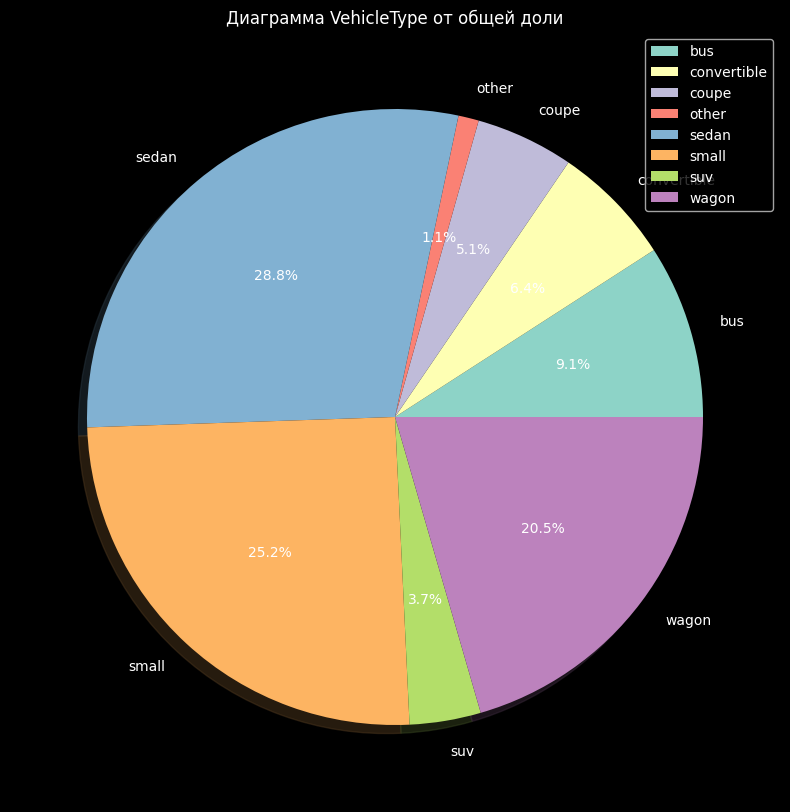

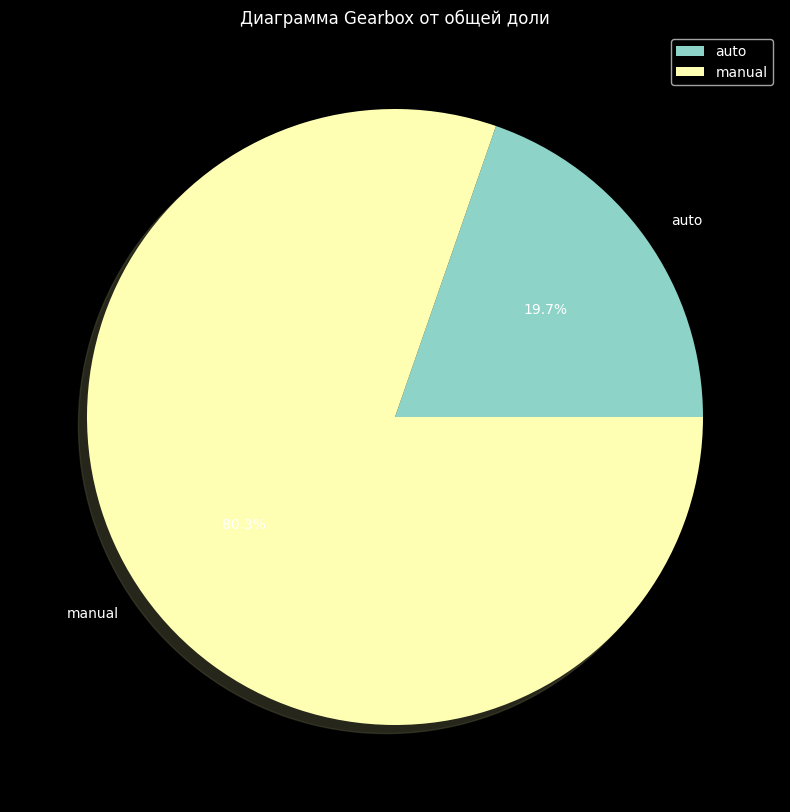

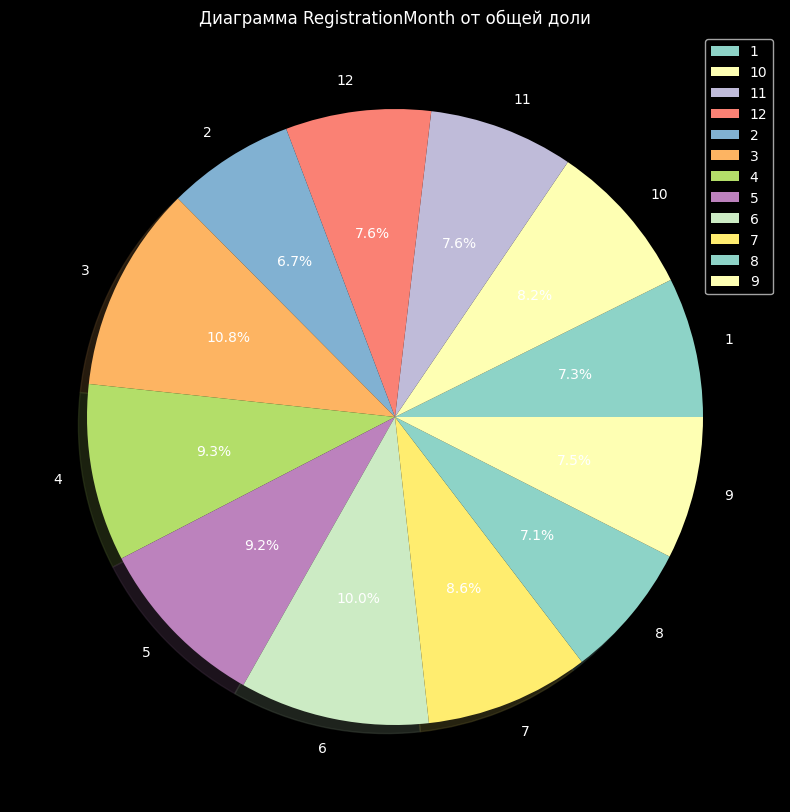

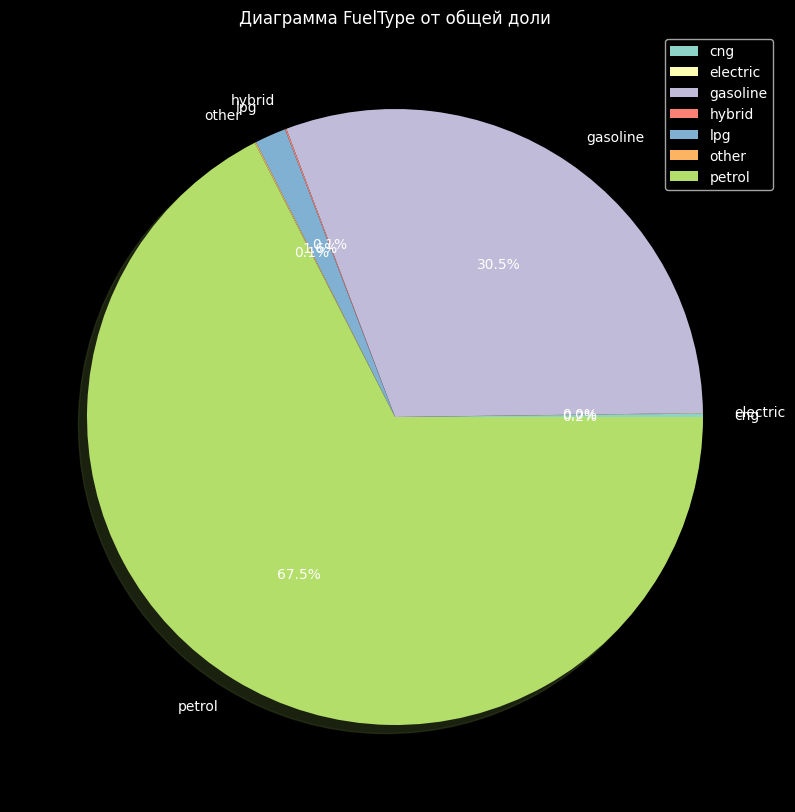

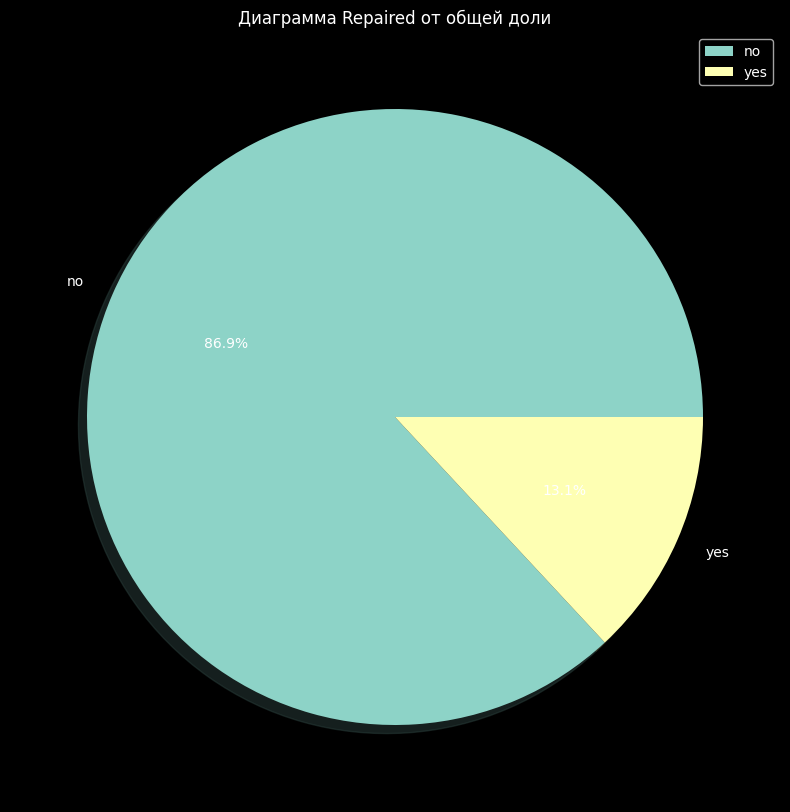

In [ ]:
for colum in ['VehicleType', 'Gearbox', 'RegistrationMonth',  'FuelType', 'Repaired']:
    fig, ax = plt.subplots(figsize=(12, 10))
    x = df.groupby(colum)['id'].count()
    x = (x/len(df) * 100).reset_index()
    labels = x[colum]
    x = x['id']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()
    print()

-Значения 'VehicleType'(тип автомобильного кузова) чаще всего встречаются кузова 'sedan', 'small', 'wagon' они забирают ~75% всех кузовов. Остальные распределенны в +- равной степени

-Значения 'Gearbox'(тип коробки передач) преобладает ручная коробка передач (80.3%), автоматическая встречается в 19.7% случаев  

-Значения 'RegistrationMonth'(месяц регистрации автомобиля) распределенны в +- равной степени

-Значения 'FuelType'(тип топлива) чаще всего встречаются автомобили которые ездят на бензине и газу ~97.5% всех автомобилей.

-Значения 'Repaired'(была машина в ремонте или нет) большинство автомобилей не было в ремонте (86.9%)

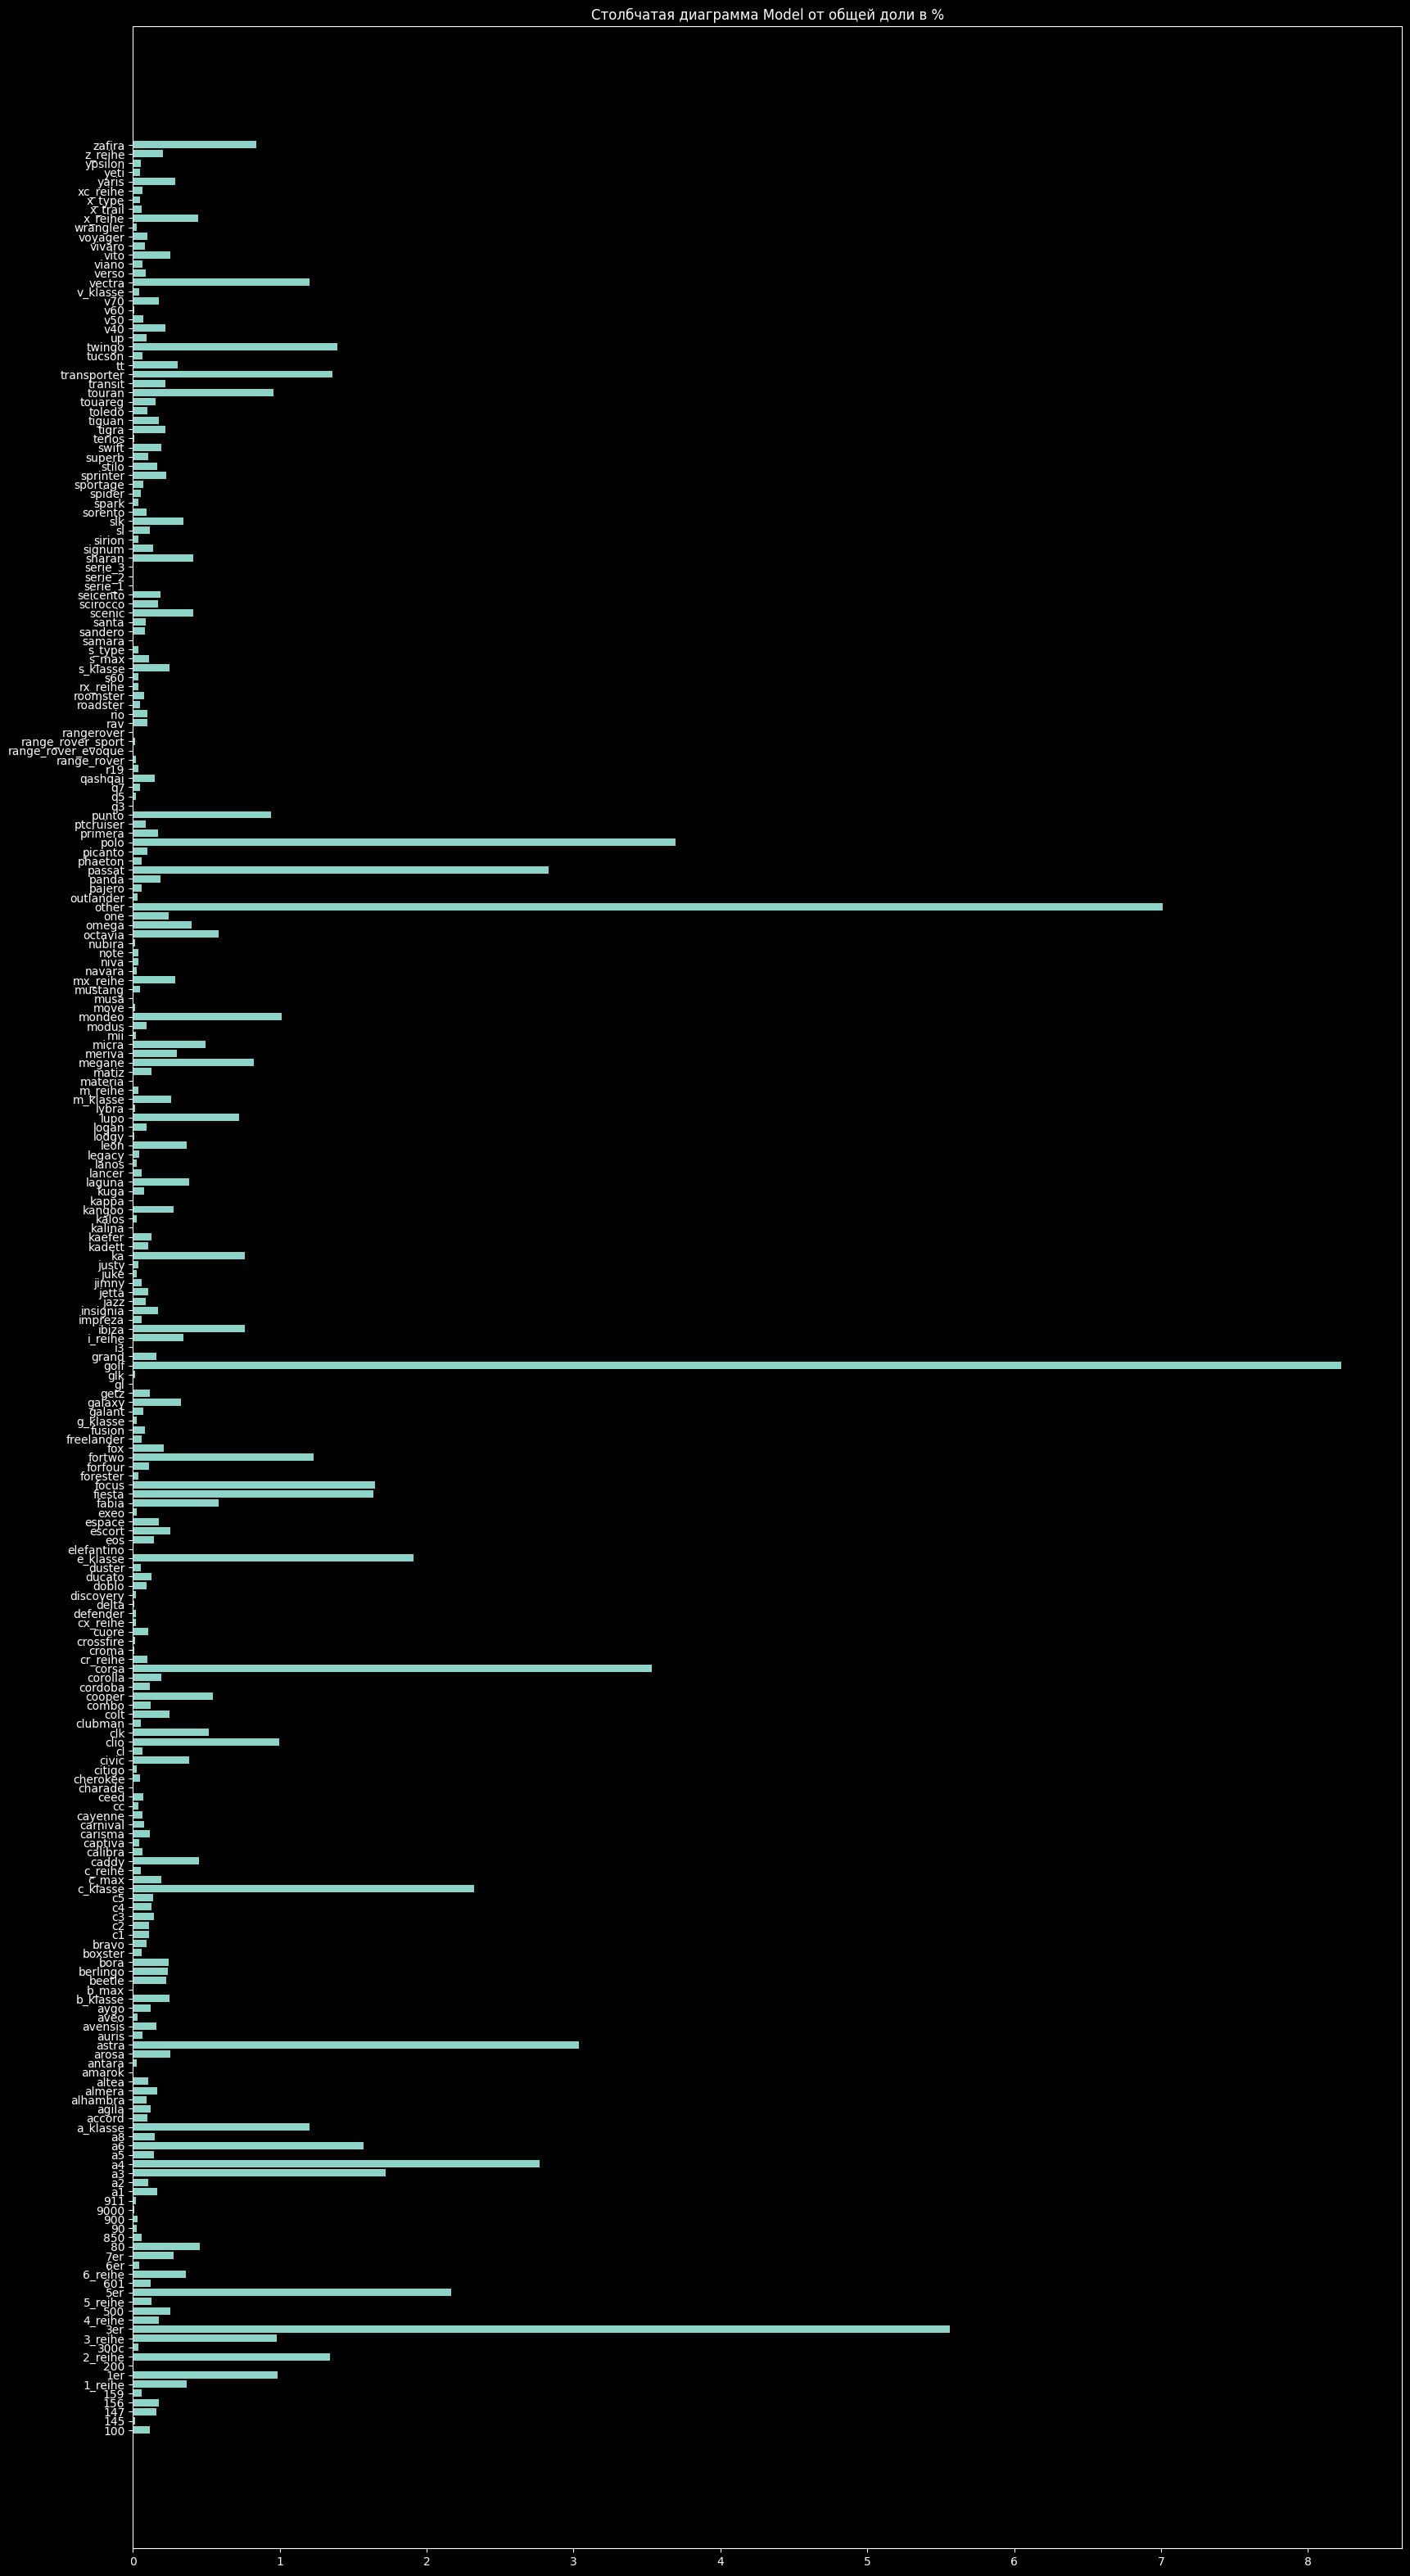

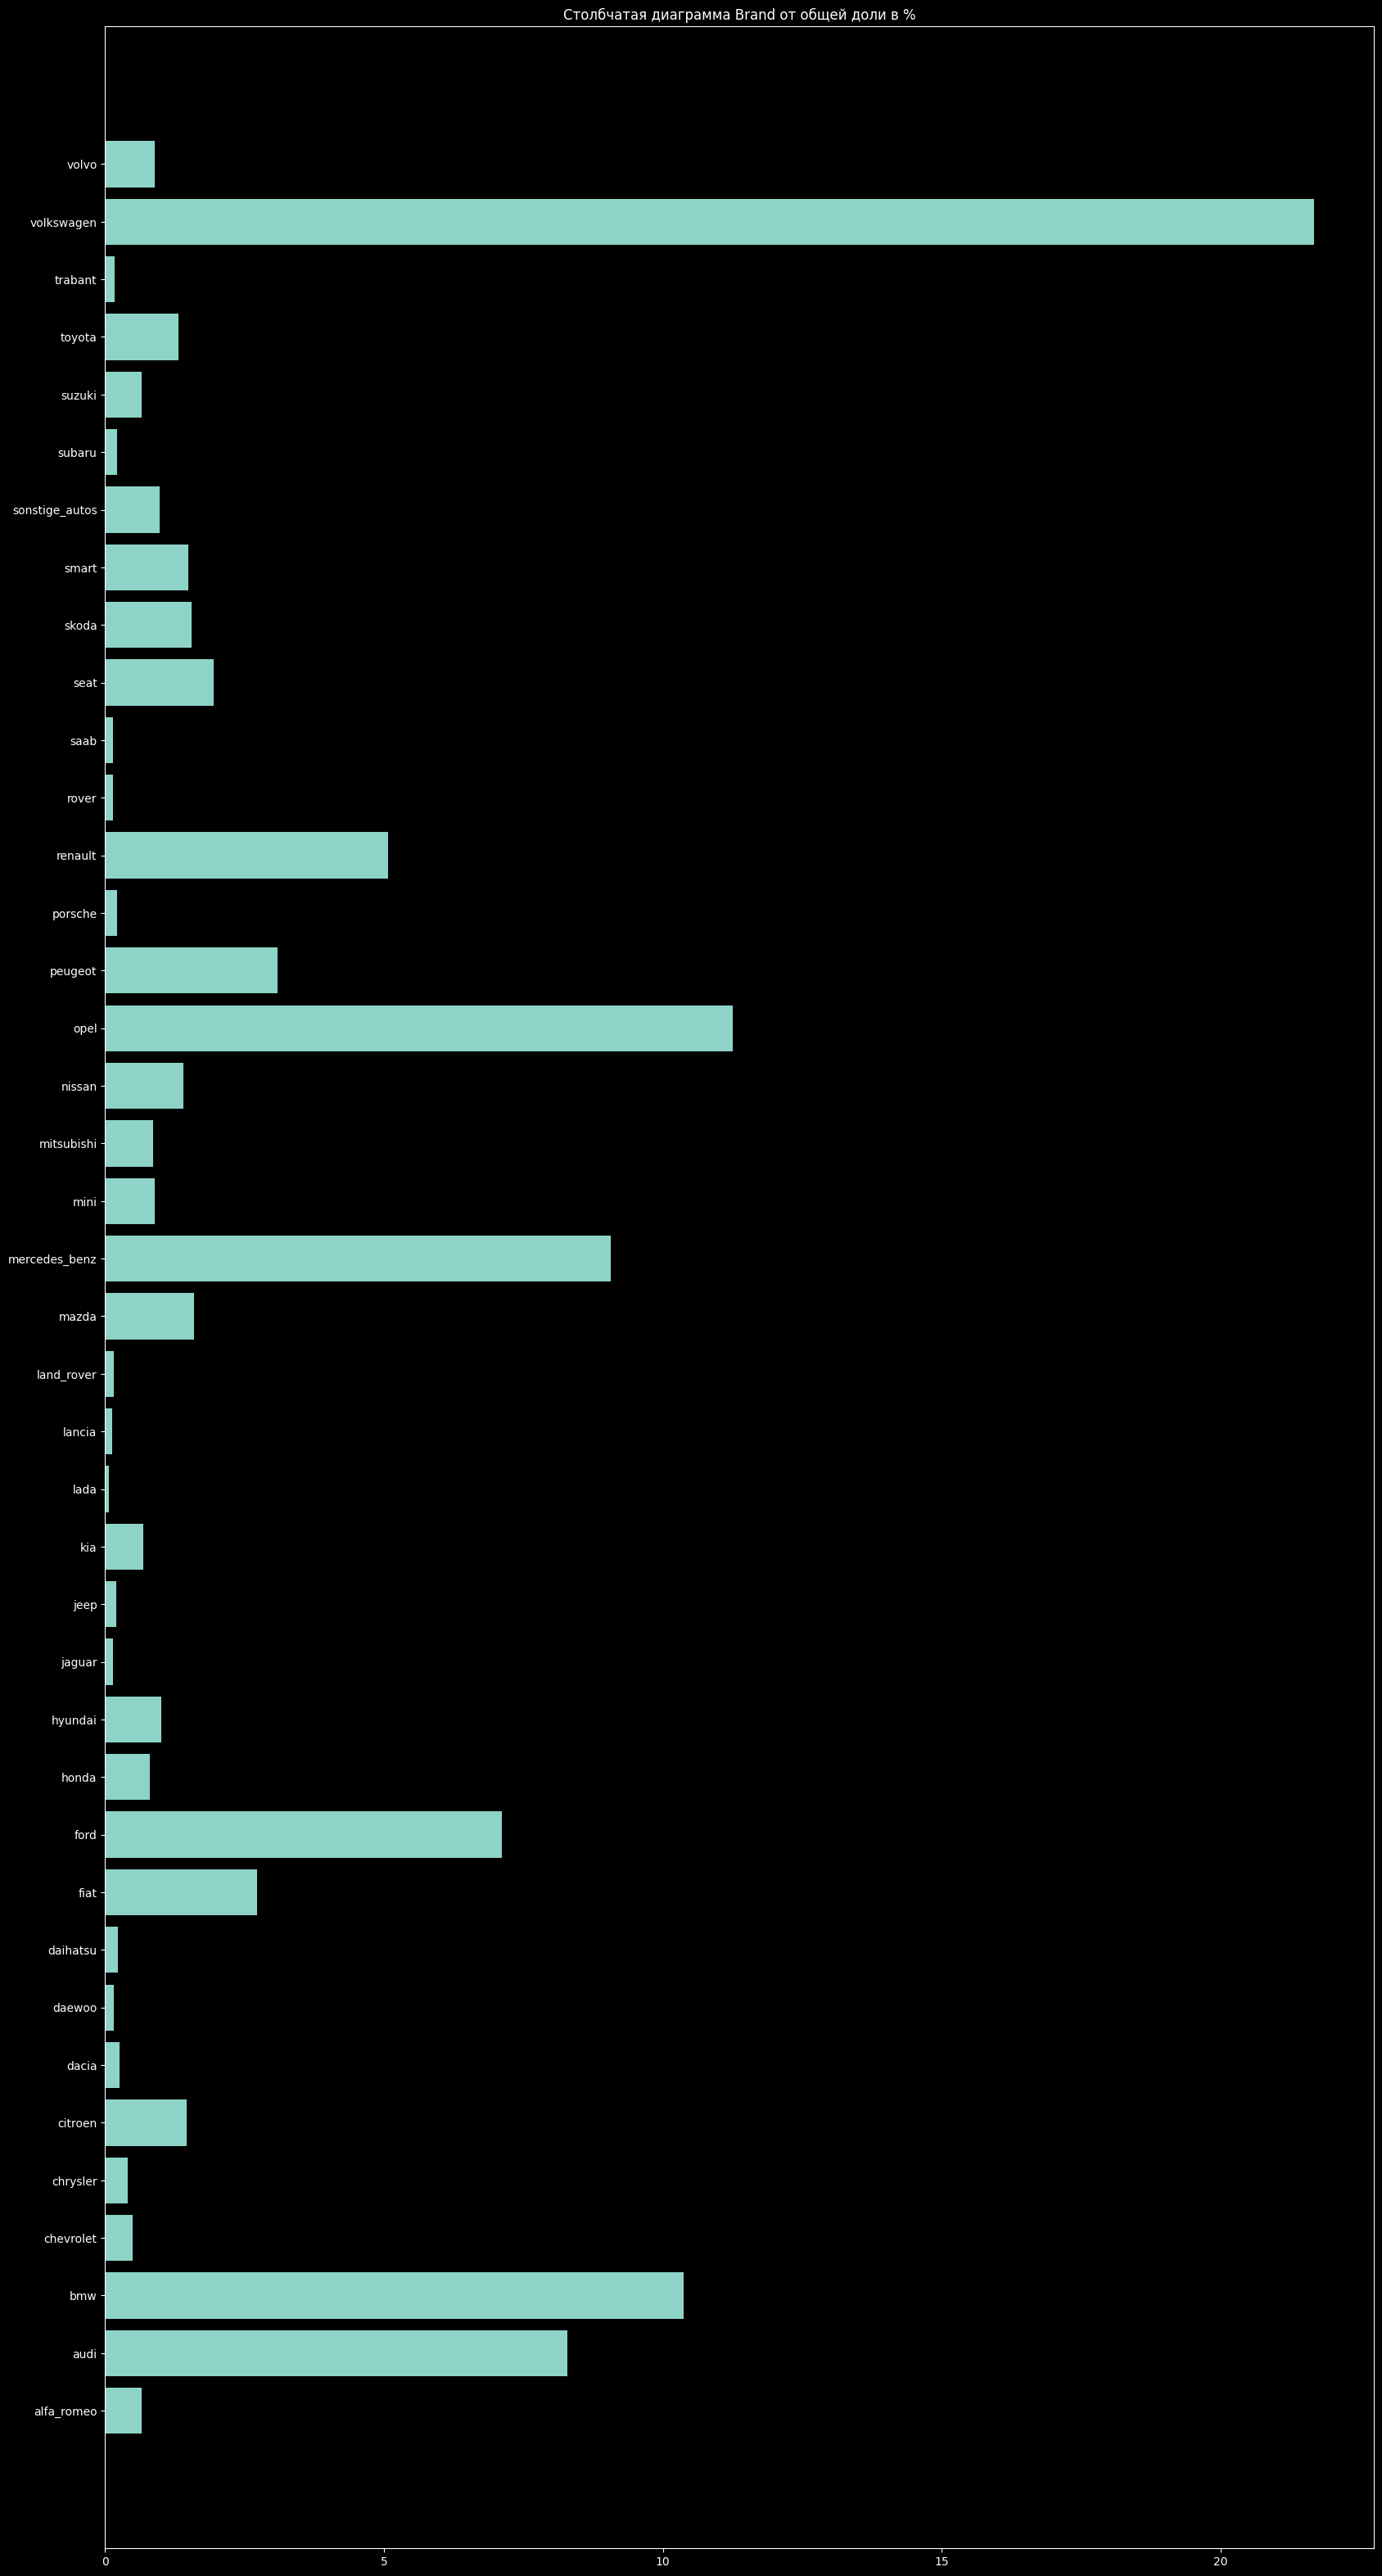

In [ ]:
for colum in ['Model', 'Brand']:
    fig, ax = plt.subplots(figsize=(20, 40))
    x = df.groupby(colum)['id'].count()
    x = (x/len(df) * 100).reset_index()
    labels = x[colum]
    x = x['id']
    plt.barh(labels, x)
    plt.title('Cтолбчатая диаграмма '+ colum +' от общей доли в %')
    plt.show()
    print()

-Очень много значений у признака 'Model'(модель автомобиля), по столбчатой диаграмме видно что преобладают типы моделей: 'polo', 'other', 'golf', 'corsa', '3er'

-Большинство значений 'Brand'(марка автомобиля) занимают: 'volkswagen', 'opel', 'mercedes_benz', 'ford', 'bmw', 'audi'

#### Кол-ые признаки

Price
count    333036.000000
mean       4378.277586
std        4502.534823
min           0.000000
25%        1000.000000
50%        2699.000000
75%        6299.250000
max       20000.000000
Name: Price, dtype: float64


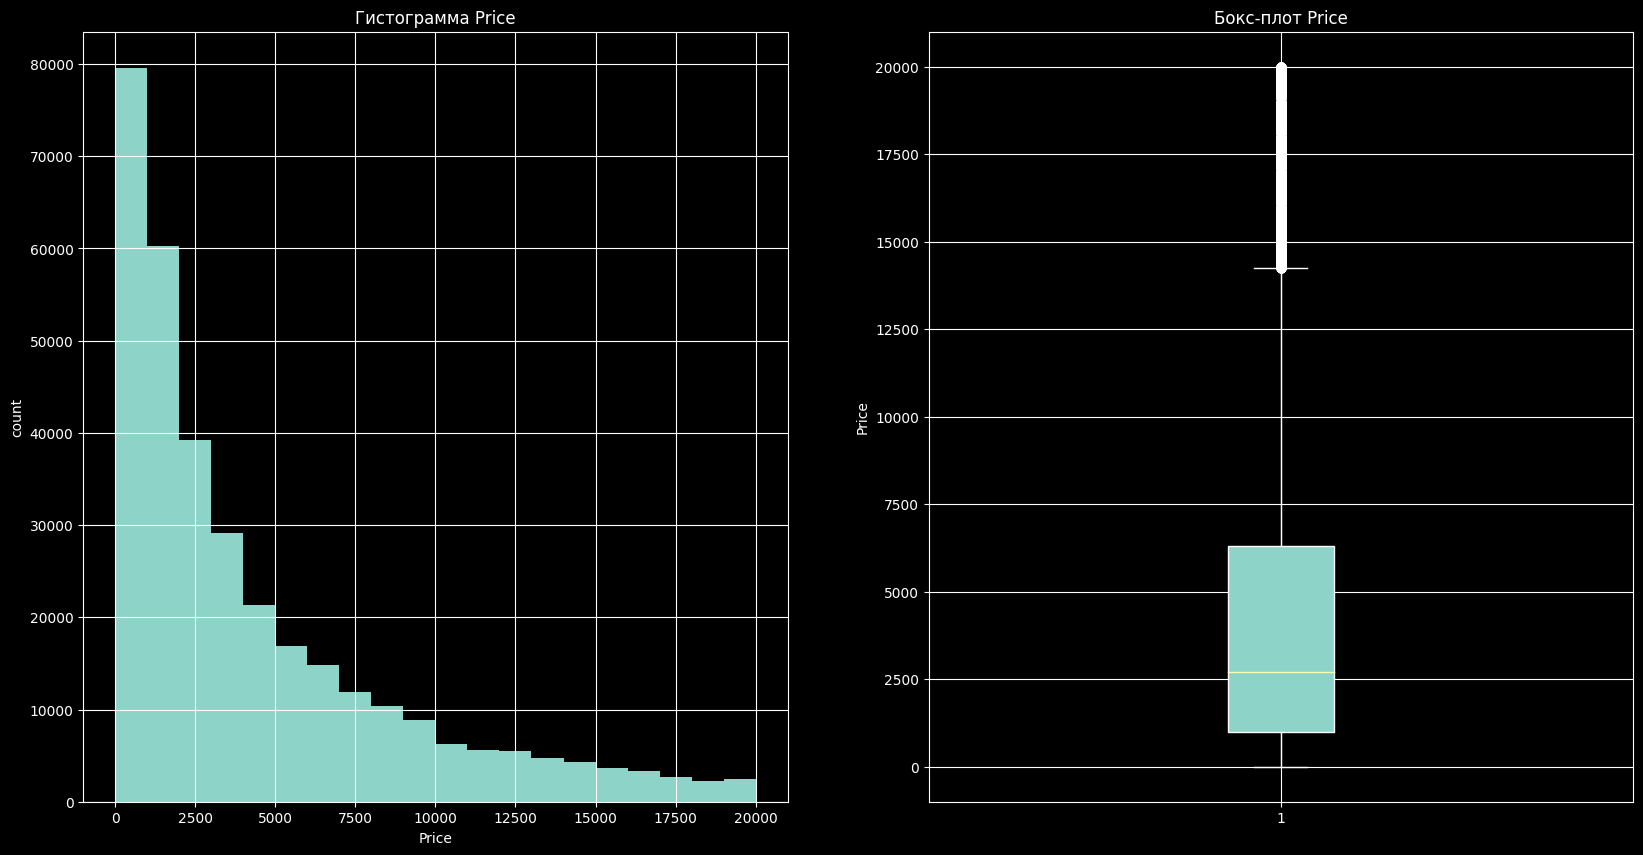

RegistrationYear
count    332523.000000
mean       2003.113851
std           7.274048
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64


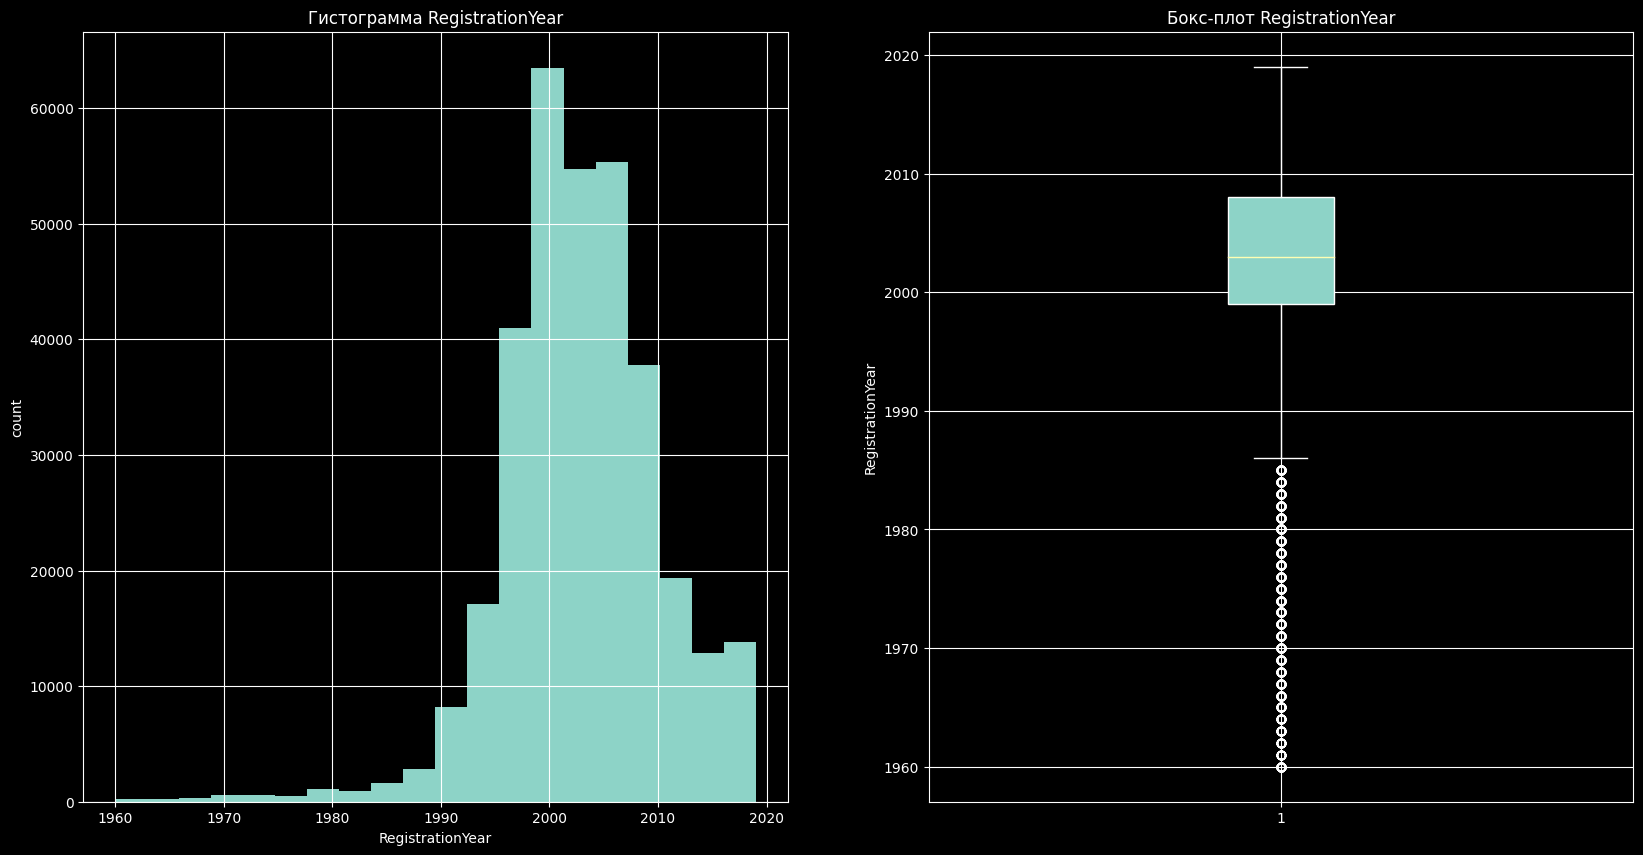

Power
count    333036.000000
mean        109.753225
std         194.288179
min           0.000000
25%          68.000000
50%         103.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64


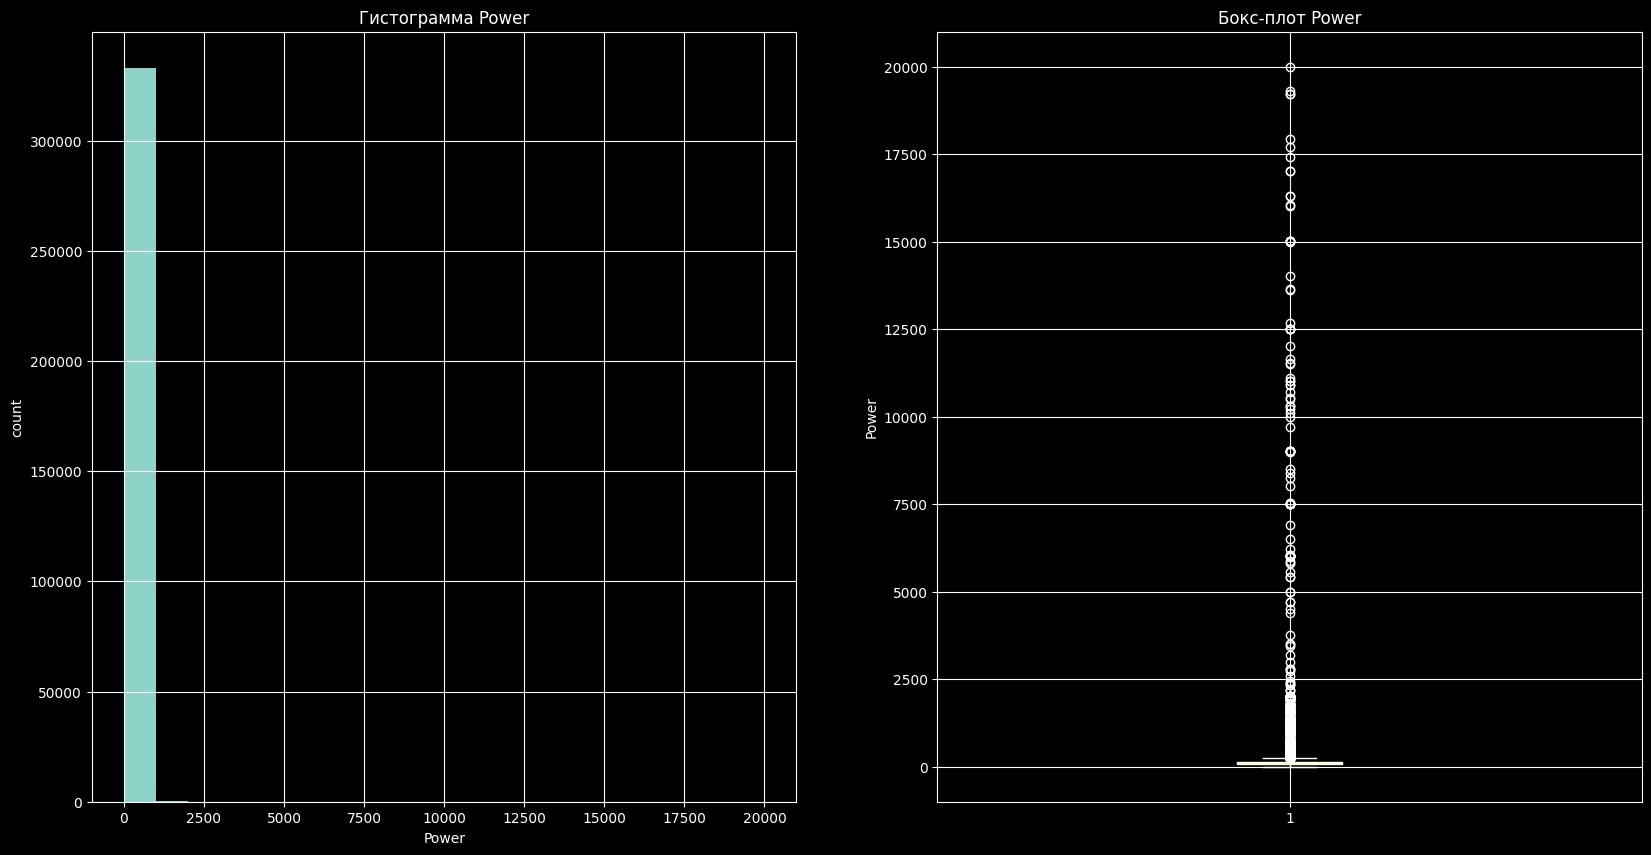

Kilometer
count    333036.000000
mean     128305.678665
std       37900.007564
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


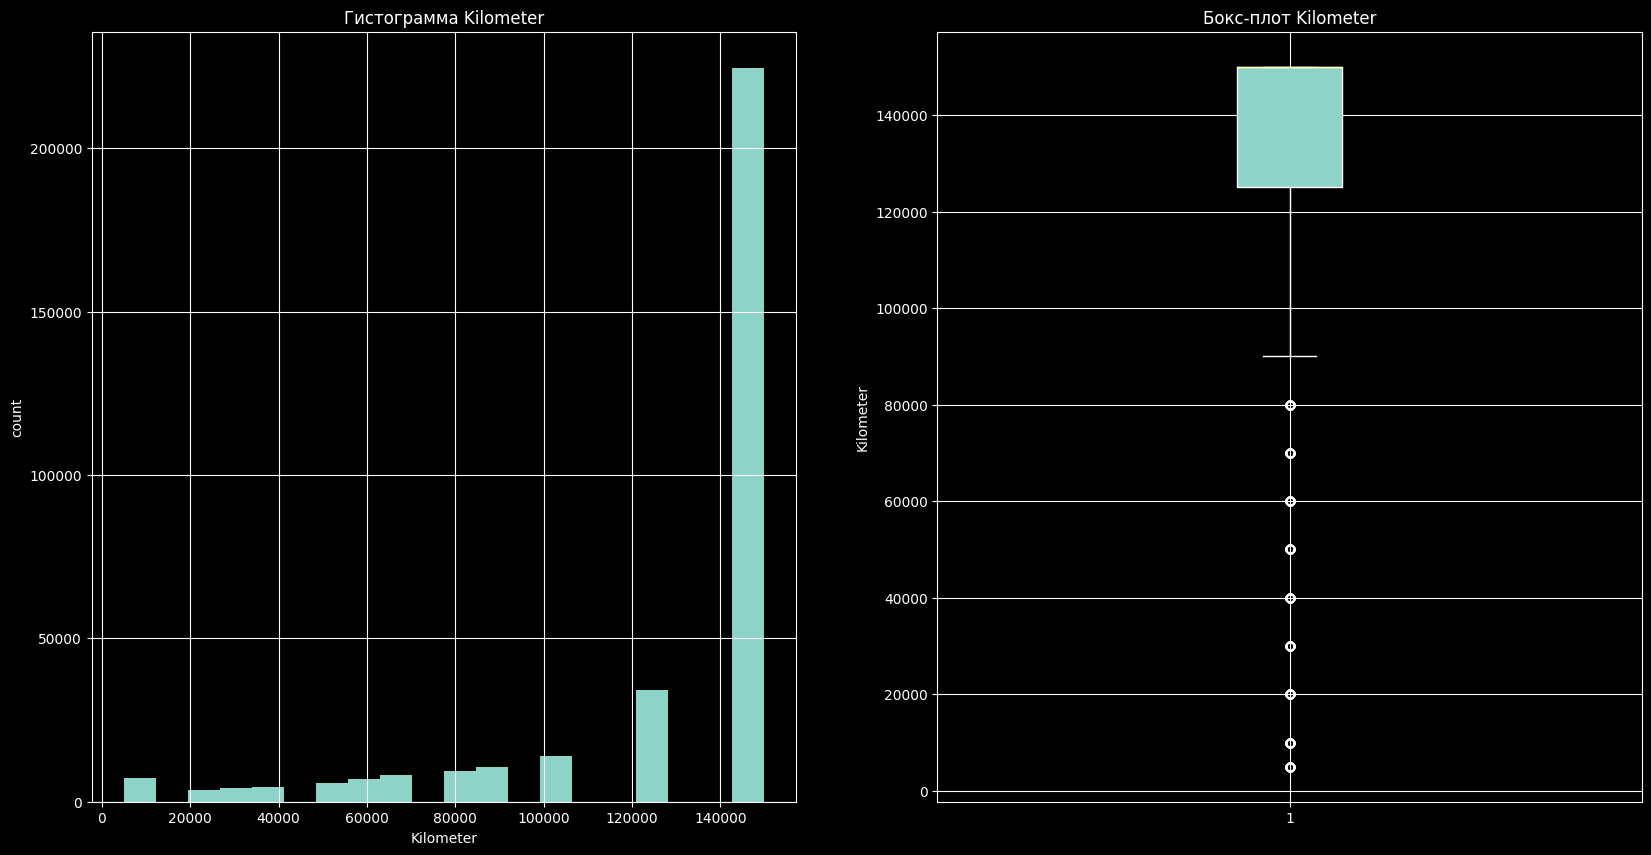

In [ ]:
for colum in ['Price', 'RegistrationYear', 'Power', 'Kilometer']:
    print(colum)
    print(df[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].hist(df[colum], bins=20)
    ax[0].set_title('Гистограмма ' + colum)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].grid(True)

    if df[colum].isna().sum() != 0:
        ax[1].boxplot(df[colum].fillna(df[colum].mean()), patch_artist=True)

    else:
        ax[1].boxplot(df[colum], patch_artist=True)

    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

-**'Price'**(цена в евро, целевой признак)  напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 20000, в среднем 4400

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'RegistrationYear'**(год регистрации автомобиля) напоминает нормальное распределение со скосом к правому краю, разброс варьируется от 1960 до 2019, в среднем 2003

Есть слегка выбивающиеся значения по левому краю распределения

-**'Power'**(мощность в л.с.) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 20000, в среднем 195

Есть аномальные значения по правому краю распределения

-**'Kilometer'**(пробег в км.) напоминает распределение Пуасона смещенное к правому краю разброс варьируется от 5000 до 150000, в среднем 128000

Есть слегка выбивающиеся значения по левому краю распределения



### Корреляционный анализ

Построим "хитмап" по матрице корреляций Фик, посмотрим на связь признаков с целевой переменной

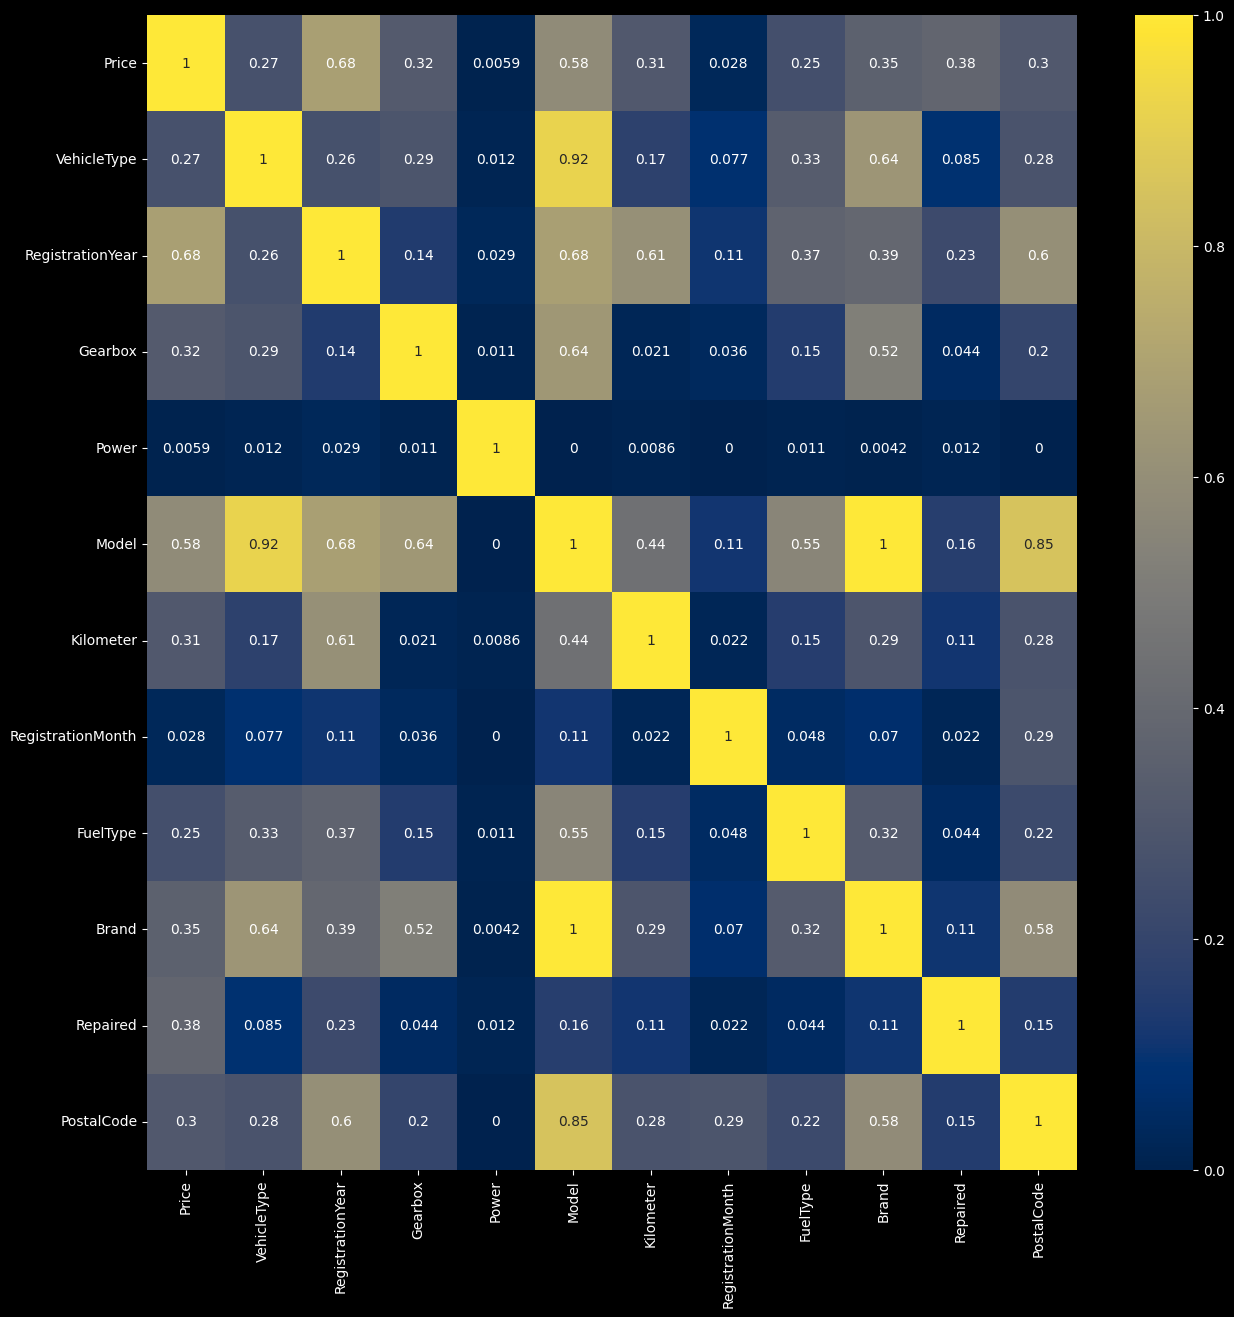

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'id'], axis=1
                                ).phik_matrix(
                                    interval_cols = ['Price','Power',
                                                     'Kilometer']
                                    ),annot=True, cmap='cividis').legend = False

Наблюдаем сильную корреляцию между 'Model' и 'Brand', т.к. оба признака категориальные оставим их как есть

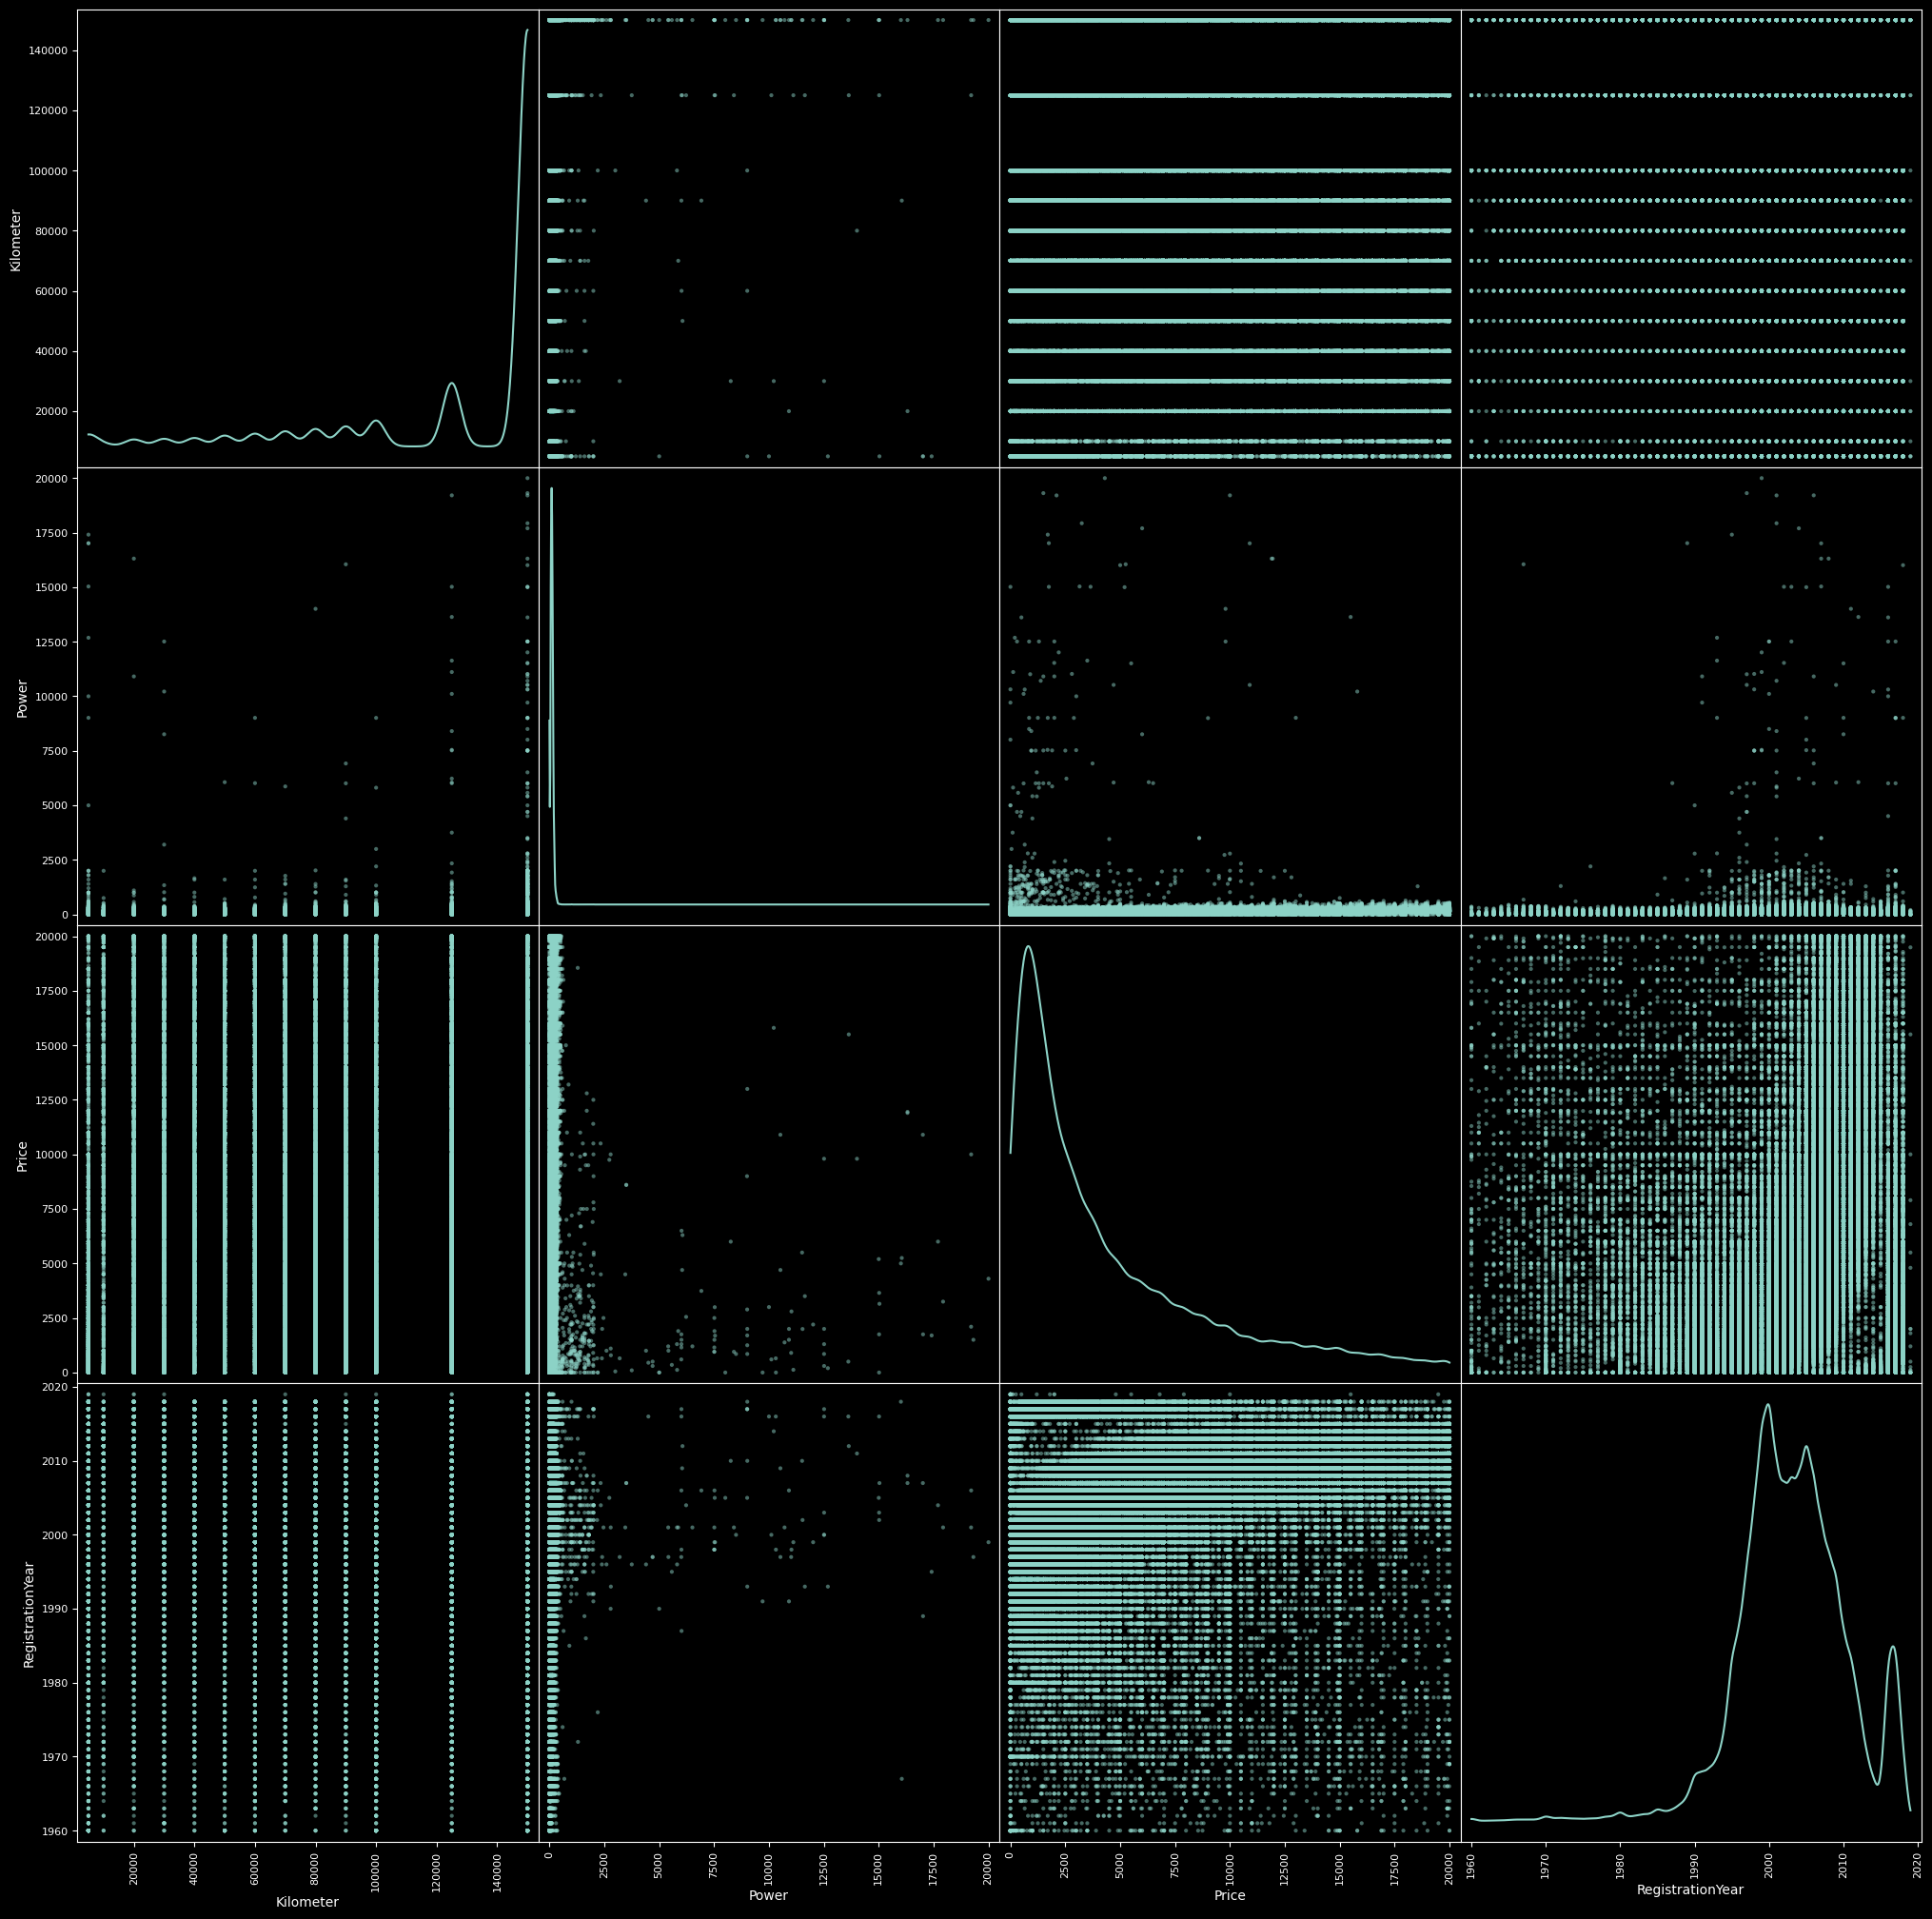

In [ ]:
corr_multi = df[['Price', 'RegistrationYear', 'Power', 'Kilometer','id']].pivot_table(
    index='id', values=['Price', 'RegistrationYear', 'Power', 'Kilometer'], aggfunc='mean')
sm = pd.plotting.scatter_matrix(corr_multi, figsize=(25, 25), diagonal='kde')

plt.show()

In [ ]:
df['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

## Обучение моделей

#### Подготовка данных

Разделяем df на: выборку для обучения и выборку для тестирования качества модели

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['DateCrawled', 'Price', 'DateCreated', 'LastSeen', 'id', 'PostalCode'], axis=1),
    df['Price'],
    test_size = 0.2,
    random_state = 42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266428 entries, 78782 to 121958
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        237471 non-null  object 
 1   RegistrationYear   266022 non-null  float64
 2   Gearbox            251161 non-null  object 
 3   Power              266428 non-null  int64  
 4   Model              251149 non-null  object 
 5   Kilometer          266428 non-null  int64  
 6   RegistrationMonth  237747 non-null  object 
 7   FuelType           240836 non-null  object 
 8   Brand              266428 non-null  object 
 9   Repaired           211792 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 22.4+ MB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66608 entries, 256076 to 216517
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   VehicleType        59425 non-null  object 
 1   RegistrationYear   66501 non-null  float64
 2   Gearbox            62860 non-null  object 
 3   Power              66608 non-null  int64  
 4   Model              62864 non-null  object 
 5   Kilometer          66608 non-null  int64  
 6   RegistrationMonth  59500 non-null  object 
 7   FuelType           60298 non-null  object 
 8   Brand              66608 non-null  object 
 9   Repaired           53181 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 5.6+ MB


Сохраним названия колонок для предобработки

In [ ]:
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']
ord_columns = []
num_columns = ['Power', 'RegistrationYear', 'Kilometer']

#### Стандартные модели

Создадим пайплайн, для разных типов данных свой пайплайн с предобработкой

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Функция для получения отсортированных значений категорий в ранговых переменных:

In [ ]:
def ord_cat(row):
    l = []
    for row in row:
        ab = list(X_train[row].unique())
        if np.nan in ab:
            ab = list(np.array(ab)[~np.isnan(np.array(ab))])
            ab.sort()
            l.append(ab)
        else:
            ab = [_ for _ in ab if _ != 'nan']
            ab.sort()
            l.append(ab)
    return l

In [ ]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=ord_cat(ord_columns),
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [ ]:
num_pipe = Pipeline(
    [('knnimputer_num', KNNImputer(n_neighbors=2, weights="uniform")),
     ('num', StandardScaler())
    ]
    )

Собираем все пайплайны в один пайплайн предобработки и указываем к каким колонкам их применить

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

Завершаем создание пайплайна с указанием модели в конце

In [ ]:
pipe_final_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=42))
])

pipe_final_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'RegistrationMonth',
                                                   'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('ord',
                                                  Pip...
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('knnimputer_num',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['Power', 'RegistrationYear',
                                                   'Kilometer'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

In [ ]:
data_preprocessor.fit_transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ..., -0.23034105,
         0.67169121, -0.74985491],
       [ 0.        ,  0.        ,  0.        , ..., -0.04772529,
        -0.8382321 ,  0.57127253],
       [ 0.        ,  0.        ,  0.        , ...,  0.1919579 ,
         0.67169121,  0.57127253],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.30609275,
        -0.42643483, -0.08929119],
       [ 0.        ,  0.        ,  0.        , ...,  0.1919579 ,
         0.53442546,  0.57127253],
       [ 0.        ,  0.        ,  0.        , ...,  0.0036354 ,
         0.80895697,  0.57127253]])

In [ ]:
%%time
param_grid_dt = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models__min_samples_leaf': range(1, 20),
        'models__max_depth': range(2, 303, 10),
        'models__min_samples_split': range(2, 20),
        'models__max_features': range(2, 13)
        }
]

randomized_search_dt = RandomizedSearchCV(
    pipe_final_dt,
    param_grid_dt,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

randomized_search_dt.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search_dt.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_dt.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'RegistrationMonth',
                                                   'FuelType', 'Brand',
          

Лучшей моделью на кросс-валидации получилась DecisionTreeRegressor(max_depth=92, max_features=11, min_samples_leaf=15, min_samples_split=8, random_state=42) RMSE: 2996. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 3 минуты 34 секунд

In [ ]:
len(X_train['Model'].unique())

250

Для модели knn убираю из данных признак 'Model', т.к. ohe_encoding наплодит 248 признаков и утяжелит обучение модели. Обучение с этим признаком занимает 3 часа 13 минут 18 секунд, лучшей моделью получилась KNeighborsRegressor(metric='euclidean', n_neighbors=21) RMSE: 2042

In [ ]:
%%time

ohe_columns_knn = ['VehicleType', 'Gearbox', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

data_preprocessor_knn = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns_knn),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

pipe_final_knn = Pipeline([
    ('preprocessor', data_preprocessor_knn),
    ('models', KNeighborsRegressor())
])

param_grid_knn = [
    # словарь для модели KNeighborsRegressor()
    {
        'models__n_neighbors': range(1, 200, 5),
        'models__metric': ['euclidean', 'cityblocks']
    }
]

randomized_search_knn = RandomizedSearchCV(
    pipe_final_knn,
    param_grid_knn,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn.fit(X_train.drop('Model', axis=1), y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search_knn.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_knn.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'RegistrationMonth',
                                                   'FuelType', 'Brand',
                   

Лучшей моделью получилась KNeighborsRegressor(metric='euclidean', n_neighbors=21) RMSE: 2280. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 1 час 10 минут 8 секунд

#### Работа с аномальными значениями

Применим алгоритм isolationForest для обработки аномальных значений, кол-во семплов которые алгоритм будет считать аномалиями выставим 5%

In [ ]:
KNNImp = KNNImputer(n_neighbors=2, weights="uniform")
X_train[num_columns] = KNNImp.fit_transform(X_train[num_columns])

In [ ]:
isolationForest = IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, random_state=42)
isolationForest.fit(X_train[num_columns])

IsolationForest(bootstrap=True, contamination=0.05, random_state=42)

In [ ]:
pred_if = isolationForest.predict(X_train[num_columns])
X_train_if = X_train.copy()
X_train_if = X_train_if.reset_index(drop=True)
X_train_if['pred_if'] = pd.Series(pred_if)
X_train_if = X_train_if[X_train_if['pred_if'] == 1].drop('pred_if', axis=1).reset_index(drop=True)
X_train_if

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,small,2008.0,manual,69.0,polo,100000.0,NaN,NaN,volkswagen,NaN
1,sedan,1997.0,manual,101.0,passat,150000.0,5,petrol,volkswagen,no
2,wagon,2008.0,manual,143.0,a4,150000.0,9,gasoline,audi,no
3,wagon,2002.0,manual,101.0,astra,150000.0,8,petrol,opel,yes
4,NaN,2016.0,manual,60.0,polo,150000.0,NaN,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
253102,small,2001.0,manual,82.0,micra,90000.0,9,petrol,nissan,no
253103,bus,2006.0,manual,131.0,scenic,125000.0,8,gasoline,renault,NaN
253104,convertible,2000.0,auto,163.0,slk,125000.0,6,petrol,mercedes_benz,no
253105,sedan,2007.0,manual,143.0,1er,150000.0,8,petrol,bmw,no


In [ ]:
y_train_if = y_train.copy()
y_train_if = y_train_if.reset_index(drop=True)
y_train_if = pd.concat([y_train_if, pd.Series(pred_if)], axis=1)
y_train_if = y_train_if[y_train_if[0] == 1].drop(0, axis=1)
y_train_if = pd.Series(y_train_if['Price']).reset_index(drop=True)
y_train_if

0          4500
1          1100
2         13480
3           699
4           700
          ...  
253102     1600
253103     3700
253104     5699
253105     6500
253106     6550
Name: Price, Length: 253107, dtype: int64

Применяем модель DecisionTreeRegressor к обработанным isolationForest данным

In [ ]:
randomized_search_dt.fit(X_train_if, y_train_if)
print('Лучшая модель и её параметры:\n\n', randomized_search_dt.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_dt.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'RegistrationMonth',
                                                   'FuelType', 'Brand',
          

Наблюдаем улучшение качества модели решающих деревьев

Взглянем на результат применения isolationForest

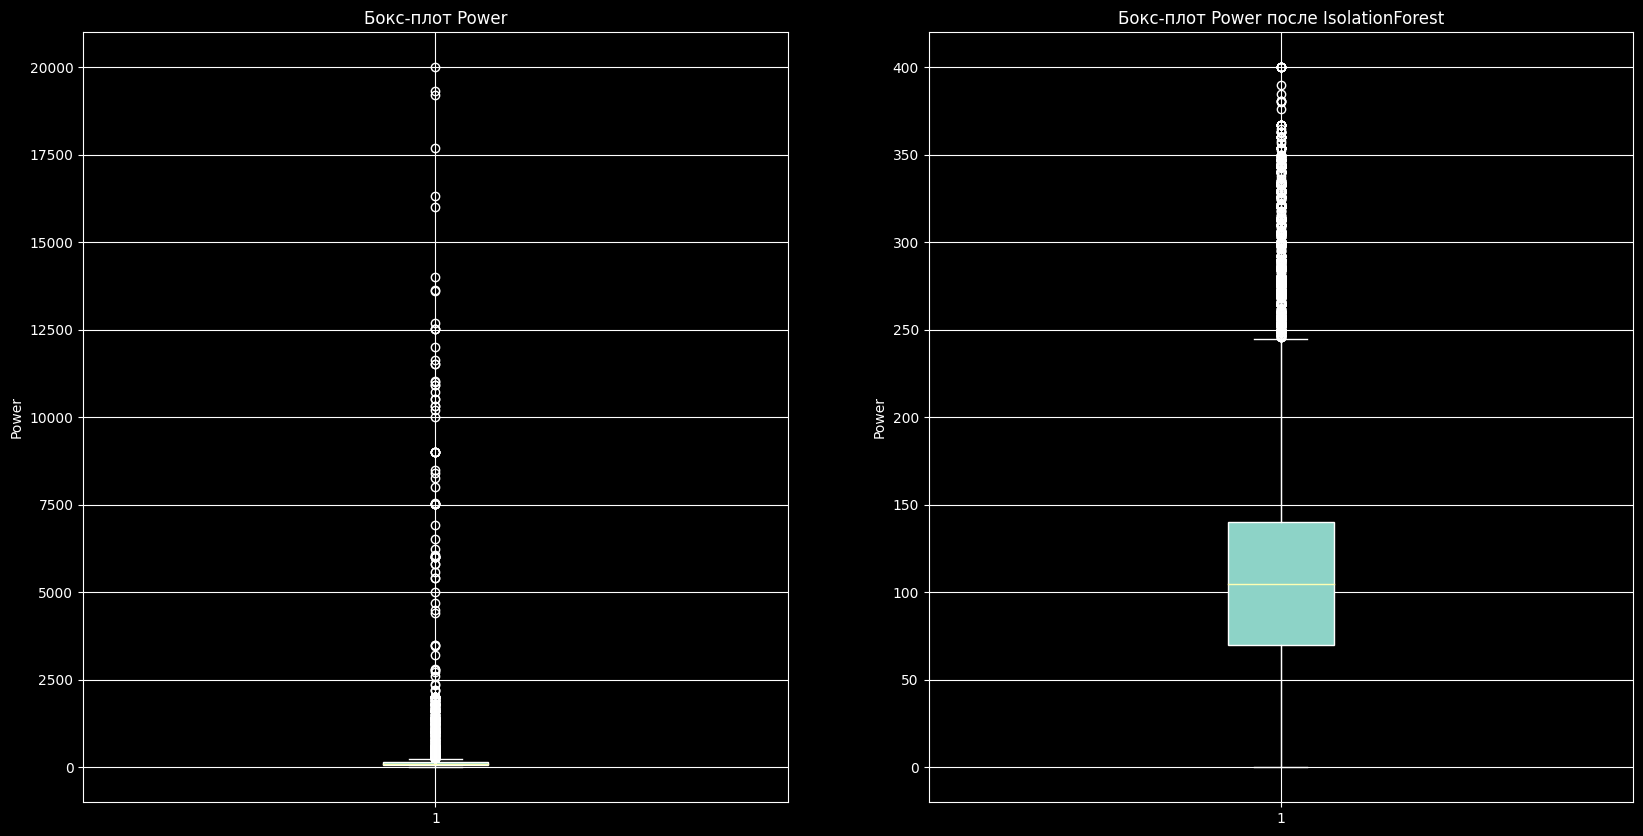

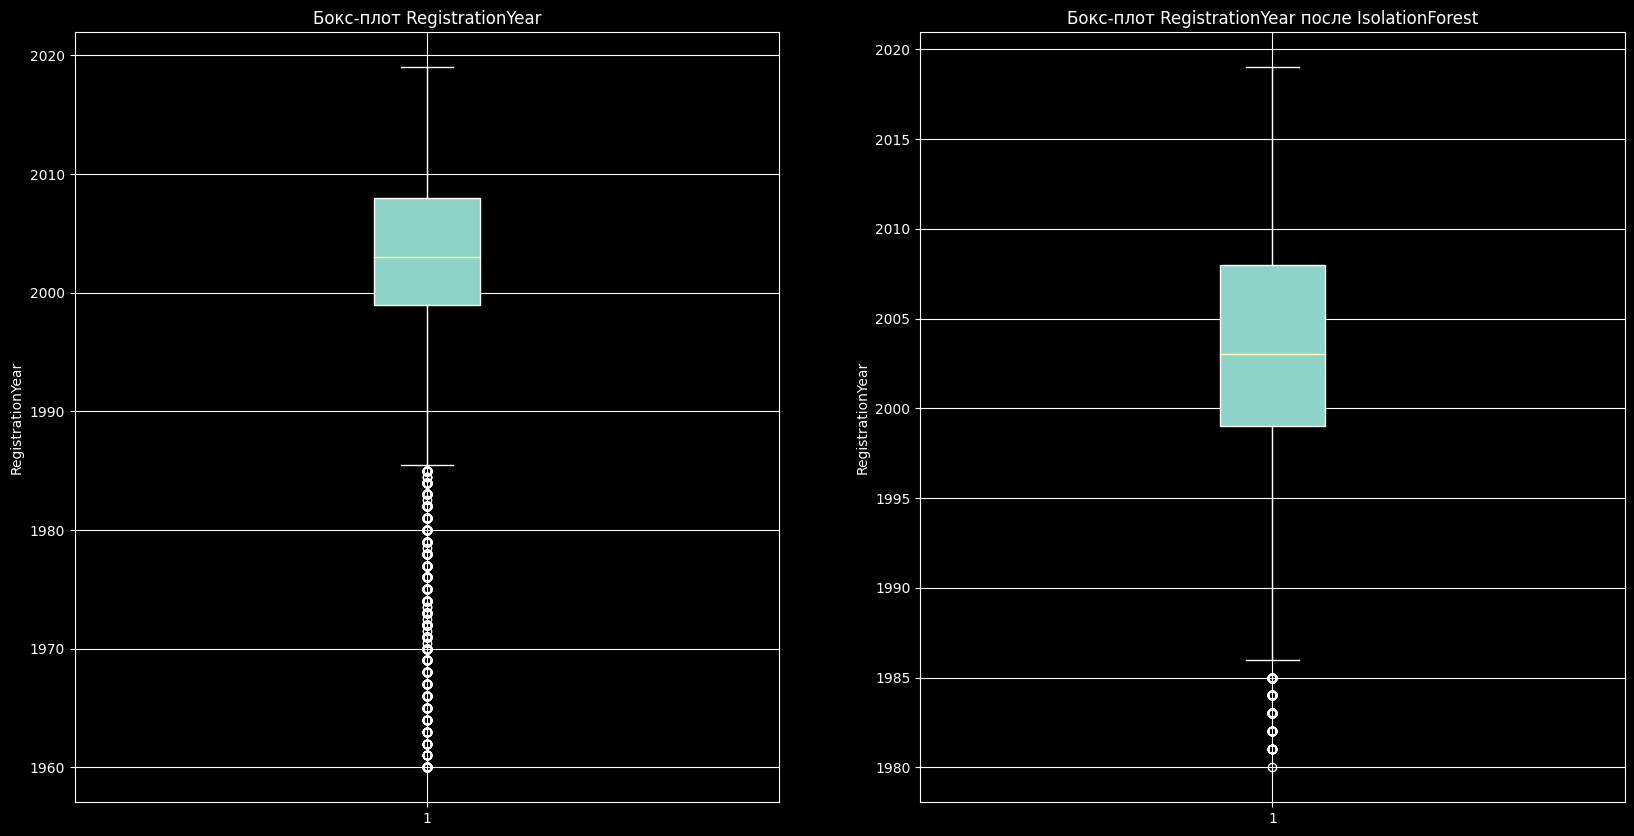

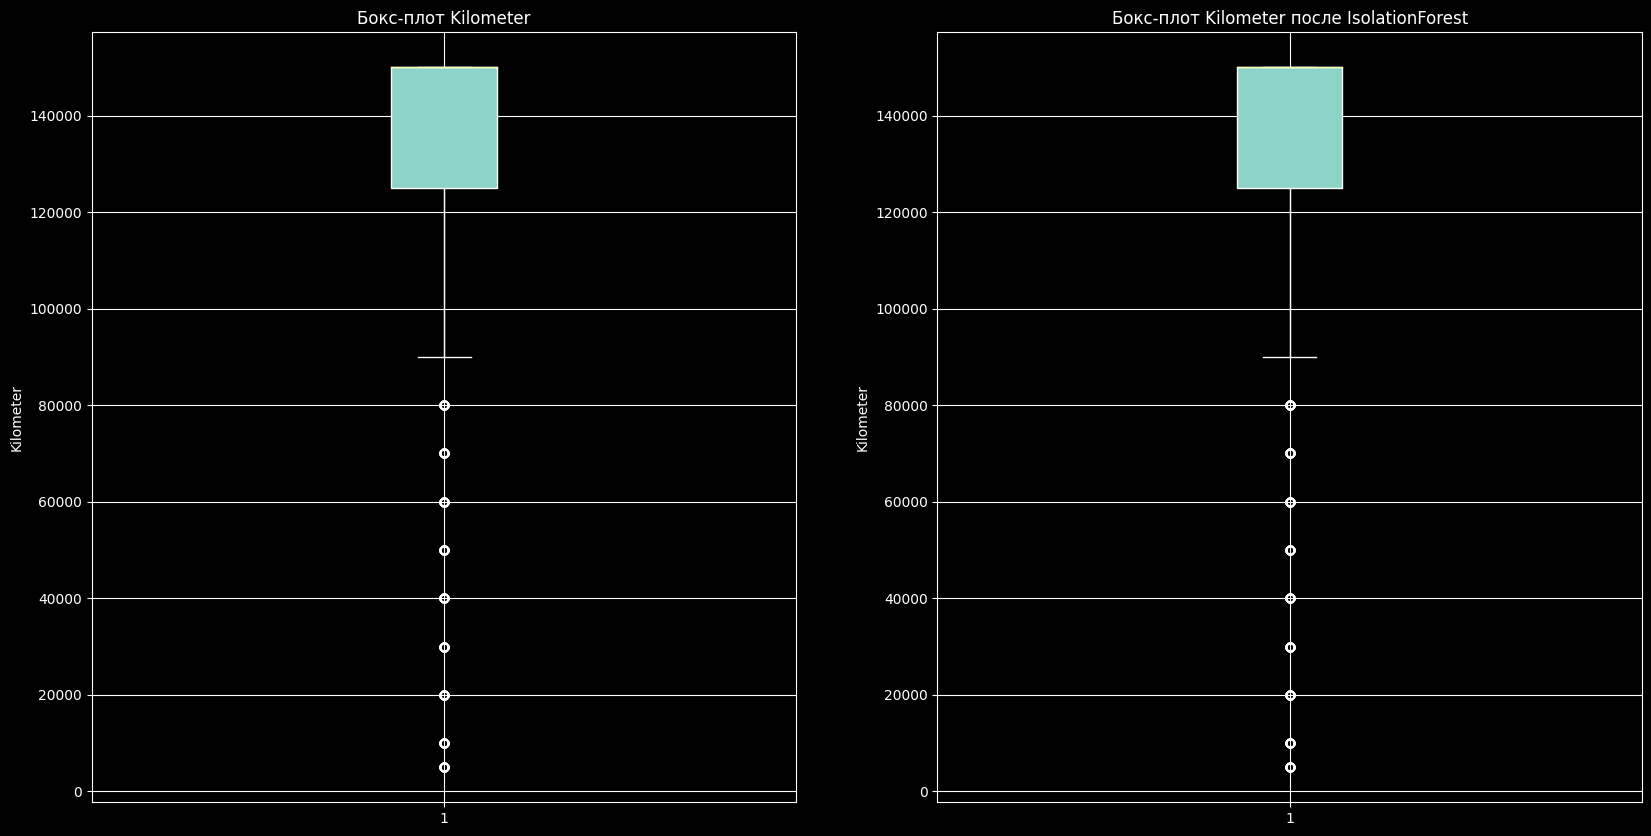

In [ ]:
for colum in num_columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].boxplot(X_train[colum], patch_artist=True)
    ax[0].set_ylabel(colum)
    ax[0].set_title('Бокс-плот ' + colum)
    ax[0].grid(True)

    ax[1].boxplot(X_train_if[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum + ' после IsolationForest')
    ax[1].grid(True)
    plt.show()
    print()

Создадим функцию для обработки аномальных значений slice_quantile, которая приводит аномальные значения к "усам боксплота"

In [ ]:
def slice_quantile(column):
    IQR = Q3 - Q1
    max_q = Q3+1.5*IQR
    min_q = Q1-1.5*IQR
    try:
        if column < min_q:
            return min_q
        elif column > max_q:
            return max_q
        else:
            return column
    except:
        return column

In [ ]:
X_train_sq = X_train.copy()
for colum in num_columns:
  Q1 = X_train_sq[colum].quantile(0.25)
  Q3 = X_train_sq[colum].quantile(0.75)
  X_train_sq[colum] = X_train_sq[colum].apply(slice_quantile)

In [ ]:
randomized_search_dt.fit(X_train_sq, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search_dt.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_dt.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'RegistrationMonth',
                                                   'FuelType', 'Brand',
          

Незначительная прибавка по целевой метрики на уровне погрешности

В дальнейшем будем использовать данные после применения isolationForest

Взглянем на результаты работы функции slice_quantile

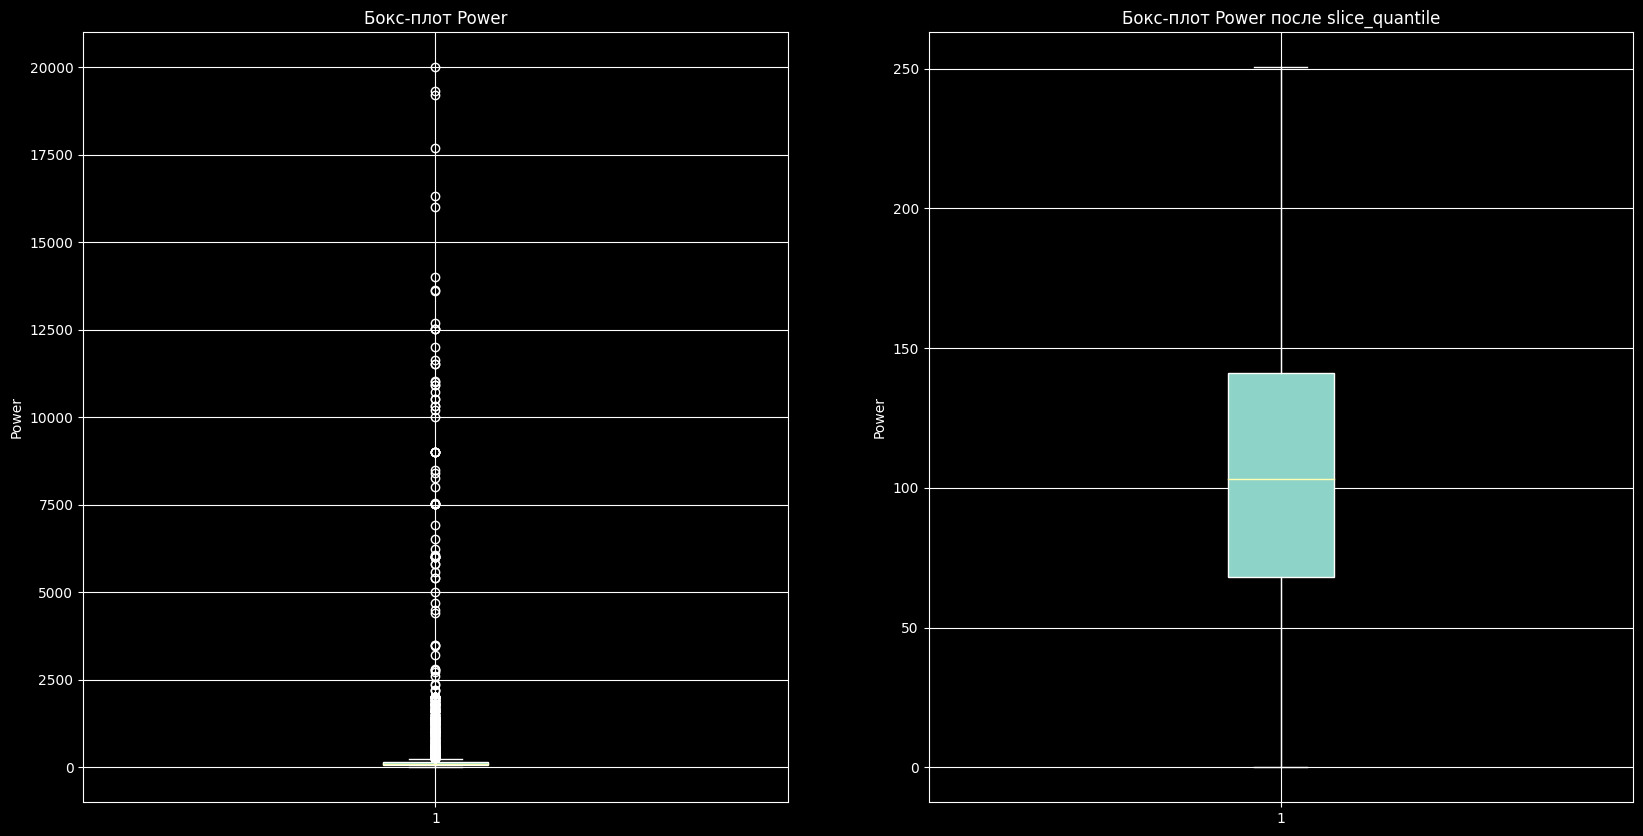

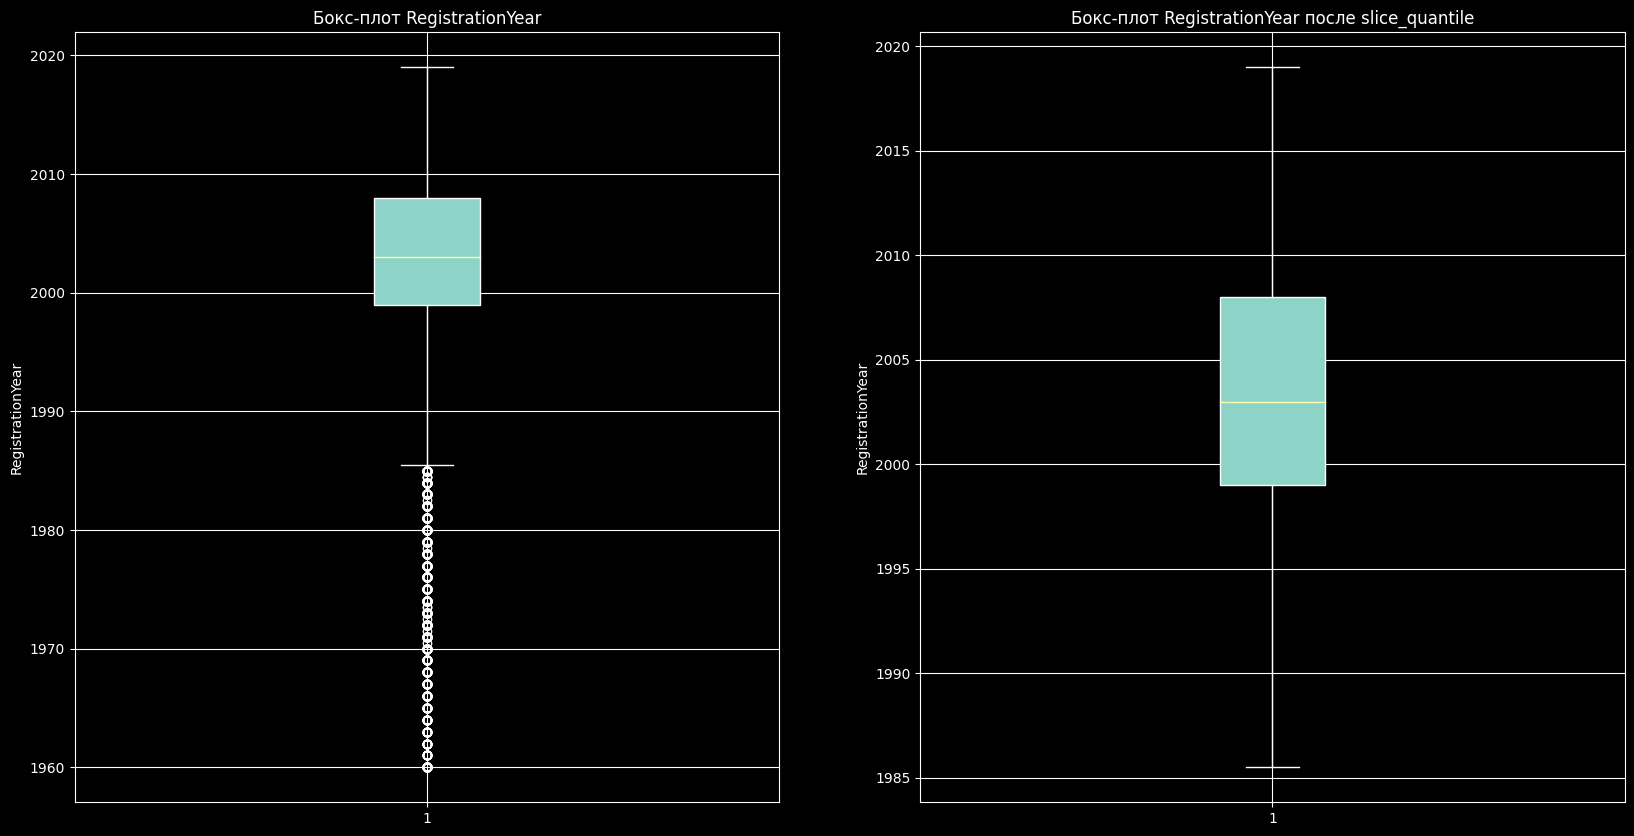

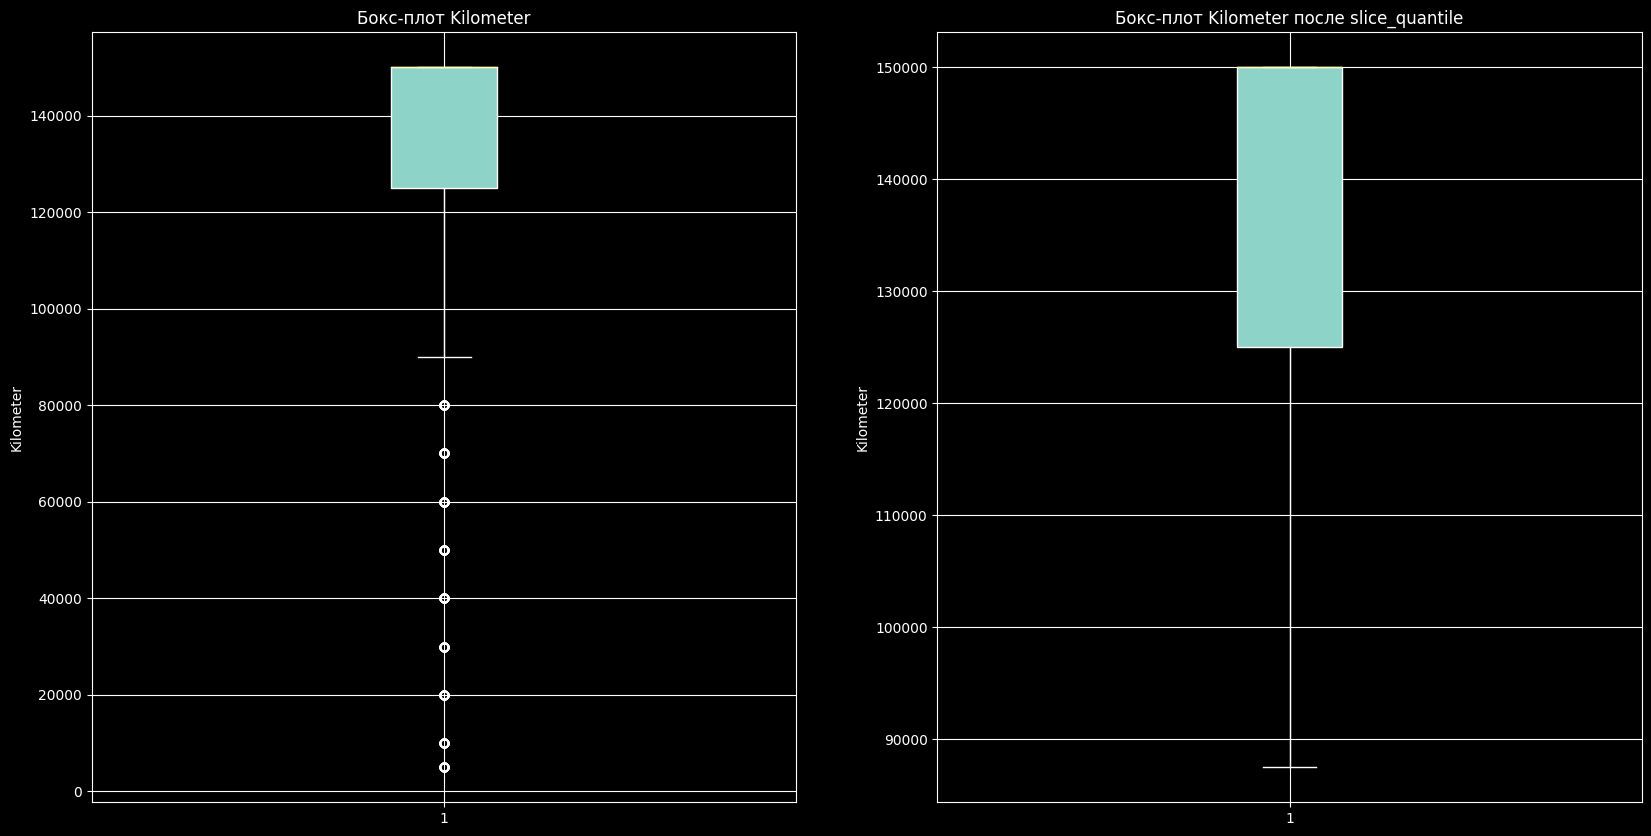

In [ ]:
for colum in num_columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].boxplot(X_train[colum], patch_artist=True)
    ax[0].set_ylabel(colum)
    ax[0].set_title('Бокс-плот ' + colum)
    ax[0].grid(True)

    ax[1].boxplot(X_train_sq[colum], patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum + ' после slice_quantile')
    ax[1].grid(True)
    plt.show()
    print()

#### Бустинги

Собираем названия категорильных признаков в один список для алгоритмов бустинга

In [ ]:
CAT_COLS = ohe_columns + ord_columns

In [ ]:
X_train_if.isna().mean()

VehicleType          0.099997
RegistrationYear     0.000000
Gearbox              0.048766
Power                0.000000
Model                0.049987
Kilometer            0.000000
RegistrationMonth    0.098693
FuelType             0.087607
Brand                0.000000
Repaired             0.195684
dtype: float64

Заполнение пропусков в категориальных признаках

In [ ]:
SimpleImp = SimpleImputer(strategy='most_frequent')
X_train_if[CAT_COLS] = SimpleImp.fit_transform(X_train_if[CAT_COLS])

In [ ]:
X_train_if.isna().mean()

VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
dtype: float64

Задаем параметры для перебора learning_rate CatBoostRegressor

In [ ]:
param_grid_cat = [
    # словарь для модели CatBoostRegressor()
    {
        'learning_rate': [i/100 for i in range(1, 50)]
    }
]

cat = CatBoostRegressor(
        iterations=500,
        cat_features= CAT_COLS,
        random_seed=42
        )

In [ ]:
%%time
randomized_search_cat = RandomizedSearchCV(
    cat,
    param_grid_cat,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

randomized_search_cat.fit(X_train_if, y_train_if, verbose=False)
print('Лучшая модель и её параметры:\n\n', randomized_search_cat.best_estimator_.get_params())
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_cat.best_score_)

Лучшая модель и её параметры:

 {'iterations': 500, 'learning_rate': 0.32, 'loss_function': 'RMSE', 'random_seed': 42, 'cat_features': ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']}
Метрика лучшей модели на кросс-валидации: 1631.5555213228217
CPU times: user 3min 54s, sys: 7.26 s, total: 4min 1s
Wall time: 44min 59s


RMSE у CatBoostRegressor взятого с learning_rate = 0.32, iterations = 500 получилось 1631. Модель обучалась включая перебор learning_rate в search на 10-ти итерациях 44 минуты 59 секунд

Задаем параметры для перебора learning_rate LGBMRegressor

In [ ]:
param_grid_lgbm = [
    # словарь для модели LGBMRegressor()
    {
        'models__learning_rate': [i/100 for i in range(1, 50)],
        'models__n_estimators': [100, 500, 1000]
    }
]

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(
        random_seed=42
        ))
])

In [ ]:
%%time
randomized_search_lgbm = RandomizedSearchCV(
    pipe_final,
    param_grid_lgbm,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=False,
    n_jobs=-1
)

randomized_search_lgbm.fit(X_train_if, y_train_if)
print('Лучшая модель и её параметры:\n\n', randomized_search_lgbm.best_estimator_.get_params())
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_lgbm.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 253107, number of used features: 301
[LightGBM] [Info] Start training from score 4303.109543
Лучшая модель и её параметры:

 {'memory': None, 'steps': [('preprocessor', ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                            

RMSE у LGBMRegressor взятого с learning_rate = 0.26, n_estimators = 500 получилось 1608. Модель обучалась включая перебор learning_rate в search на 10-ти итерациях 4 минуты 40 секунды

#### Бэггинг

Обучим алгоритм RandomForestClassifier

In [ ]:
%%time

pipe_final_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestRegressor(random_state=42))
])

param_grid_rf = [
    # словарь для модели RandomForestRegressor()
    {
        'models__min_samples_leaf': range(1, 20),
        'models__max_depth': range(2, 303, 10),
        'models__min_samples_split': range(2, 20),
        'models__max_features': range(2, 13),
        'models__n_estimators': range(10, 101)
        }
]

randomized_search_rf = RandomizedSearchCV(
    pipe_final_rf,
    param_grid_rf,
    cv=3,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train_if, y_train_if)
print('Лучшая модель и её параметры:\n\n', randomized_search_rf.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1*randomized_search_rf.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'RegistrationMonth',
                                                   'FuelType', 'Brand',
          

RMSE у RandomForestRegressor получилось 1749. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 19 минут 50 секунд

## Анализ моделей

Учитывая критерии, которые важны заказчику: качество предсказания;
время обучения модели;
время предсказания модели.

Отберем лучшие модели по каждому критерию

### Качество предсказания

Лучше всего в точности предсказания себя показали модели бустинга: CatBoostRegressor, LGBMRegressor. LGBMRegressor обучалась намного быстрее и результат показала чуть более точный, поэтому ее будем использовать для получения предсказания на тесте

In [ ]:
X_test[CAT_COLS] = SimpleImp.transform(X_test[CAT_COLS])

In [ ]:
print ('Метрика самой точной модели на тестовой выборке:', mean_squared_error(np.asarray(y_test),
                                                                    randomized_search_lgbm.best_estimator_.predict(X_test), squared=False))

Метрика самой точной модели на тестовой выборке: 1866.1197196989115


### Время обучения модели

In [ ]:
%%time
dt = DecisionTreeRegressor(max_depth=212, max_features=11, min_samples_leaf=18, random_state=42)
dt.fit(data_preprocessor.fit_transform(X_train_if), y_train_if)

CPU times: user 2.85 s, sys: 1.04 s, total: 3.89 s
Wall time: 3.9 s


DecisionTreeRegressor(max_depth=212, max_features=11, min_samples_leaf=18,
                      random_state=42)

In [ ]:
%%time
knn = KNeighborsRegressor(metric='euclidean', n_neighbors=21)
knn.fit(data_preprocessor_knn.fit_transform(X_train_if.drop('Model', axis=1)), y_train_if)

CPU times: user 1.1 s, sys: 197 ms, total: 1.3 s
Wall time: 1.31 s


KNeighborsRegressor(metric='euclidean', n_neighbors=21)

In [ ]:
%%time
cat = CatBoostRegressor(learning_rate=0.32, iterations=500, cat_features= CAT_COLS, random_seed=42)
cat.fit(X_train_if, y_train_if, verbose=False)

CPU times: user 3min 22s, sys: 2.25 s, total: 3min 24s
Wall time: 2min 22s


In [ ]:
%%time
lgbm = LGBMRegressor(learning_rate=0.26, n_estimators=500, random_seed=42)
lgbm.fit(data_preprocessor.fit_transform(X_train_if), y_train_if)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 253107, number of used features: 301
[LightGBM] [Info] Start training from score 4303.109543
CPU times: user 11 s, sys: 1.06 s, total: 12.1 s
Wall time: 12.9 s


LGBMRegressor(learning_rate=0.26, n_estimators=500, random_seed=42)

In [ ]:
%%time
rf = RandomForestRegressor(max_depth=272, max_features=11 ,min_samples_split=16, n_estimators=86, random_state=42)
rf.fit(data_preprocessor.fit_transform(X_train_if), y_train_if)

CPU times: user 1min 53s, sys: 1.53 s, total: 1min 55s
Wall time: 2min 11s


RandomForestRegressor(max_depth=272, max_features=11, min_samples_split=16,
                      n_estimators=86, random_state=42)

Самой быстрой в обучении получилась модель KNeighborsRegressor, на обучение она тратит 1.31 секунды

### Время предсказания модели

In [ ]:
%%time
mean_squared_error(np.asarray(y_test), randomized_search_dt.best_estimator_.predict(X_test), squared=False)

CPU times: user 2.34 s, sys: 979 ms, total: 3.31 s
Wall time: 2.85 s


2799.7333662610113

In [ ]:
%%time
mean_squared_error(np.asarray(y_test), randomized_search_knn.best_estimator_.predict(X_test.drop('Model', axis=1)), squared=False)

CPU times: user 3min 54s, sys: 771 ms, total: 3min 55s
Wall time: 2min 57s


2240.636679583087

In [ ]:
%%time
mean_squared_error(np.asarray(y_test), randomized_search_cat.best_estimator_.predict(X_test), squared=False)

CPU times: user 732 ms, sys: 0 ns, total: 732 ms
Wall time: 487 ms


1913.4620467058721

In [ ]:
%%time
mean_squared_error(np.asarray(y_test), randomized_search_lgbm.best_estimator_.predict(X_test), squared=False)

CPU times: user 4.22 s, sys: 861 ms, total: 5.08 s
Wall time: 5.29 s


1866.1197196989115

In [ ]:
%%time
mean_squared_error(np.asarray(y_test), randomized_search_rf.best_estimator_.predict(X_test), squared=False)

CPU times: user 5.55 s, sys: 950 ms, total: 6.5 s
Wall time: 6.18 s


1963.048762352544

Самой быстрой в получение предсказания является модель  CatBoostRegressor на получение предсказания она тратит 487 миллисекунд

### Итоговая таблица

Соберем резулультаты исследования в одну общую таблицу:

In [ ]:
data = [["DecisionTreeRegressor", "3.9 секунд", "2.85 секунд", "2659"],
        ["KNeighborsRegressor", "1.3 секунд", "2 минуты 57 секунд", "2148"],
        ["CatBoostRegressor", "2 минуты 22 секунды", "487 миллисекунд", "1631"],
        ["LGBMRegressor", "12.9 секунд", "5.29 секунд", "1608"],
        ["RandomForestRegressor", "2 минуты 11 секунд", "6.18 секунд", "1790"]]
column = ["модель","время обучения", "время получения предсказания", "Результат RMSE на валидации"]
data = pd.DataFrame(data, columns=column)

data

,модель,время обучения,время получения предсказания,Результат RMSE на валидации
0,DecisionTreeRegressor,3.9 секунд,2.85 секунд,2659
1,KNeighborsRegressor,1.3 секунд,2 минуты 57 секунд,2148
2,CatBoostRegressor,2 минуты 22 секунды,487 миллисекунд,1631
3,LGBMRegressor,12.9 секунд,5.29 секунд,1608
4,RandomForestRegressor,2 минуты 11 секунд,6.18 секунд,1790


В продакшн рекомендую модель LGBMRegressor, оптимальна по необходимым критериям

In [ ]:
X = df.drop(['DateCrawled', 'Price', 'DateCreated', 'LastSeen', 'id', 'PostalCode'], axis=1)
y = df['Price']

In [ ]:
KNNImp = KNNImputer(n_neighbors=2, weights="uniform")
X[num_columns] = KNNImp.fit_transform(X[num_columns])

isolationForest = IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, random_state=42)
isolationForest.fit(X[num_columns])
pred_if = isolationForest.predict(X[num_columns])

X_train_if = X.copy()
X_train_if = X_train_if.reset_index(drop=True)
X_train_if['pred_if'] = pd.Series(pred_if)
X_train_if = X_train_if[X_train_if['pred_if'] == 1].drop('pred_if', axis=1).reset_index(drop=True)
X_train_if

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,NaN,1993.0,manual,0.0,golf,150000.0,NaN,petrol,volkswagen,NaN
1,coupe,2011.0,manual,190.0,NaN,125000.0,5,gasoline,audi,yes
2,suv,2004.0,auto,163.0,grand,125000.0,8,gasoline,jeep,NaN
3,small,2001.0,manual,75.0,golf,150000.0,6,petrol,volkswagen,no
4,small,2008.0,manual,69.0,fabia,90000.0,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
316382,sedan,2004.0,manual,225.0,leon,150000.0,5,petrol,seat,yes
316383,NaN,2005.0,manual,0.0,colt,150000.0,7,petrol,mitsubishi,yes
316384,convertible,2000.0,auto,101.0,fortwo,125000.0,3,petrol,smart,no
316385,bus,1996.0,manual,102.0,transporter,150000.0,3,gasoline,volkswagen,no


In [ ]:
y_train_if = y.copy()
y_train_if = y_train_if.reset_index(drop=True)
y_train_if = pd.concat([y_train_if, pd.Series(pred_if)], axis=1)
y_train_if = y_train_if[y_train_if[0] == 1].drop(0, axis=1)
y_train_if = pd.Series(y_train_if['Price']).reset_index(drop=True)
y_train_if

0           480
1         18300
2          9800
3          1500
4          3600
          ...  
316382     3200
316383        0
316384     1199
316385     9200
316386     3400
Name: Price, Length: 316387, dtype: int64

In [ ]:
SimpleImp = SimpleImputer(strategy='most_frequent')
X_train_if[CAT_COLS] = SimpleImp.fit_transform(X_train_if[CAT_COLS])

In [ ]:
model = LGBMRegressor(learning_rate=0.26, n_estimators=500, random_seed=42)
model.fit(data_preprocessor.fit_transform(X_train_if), y_train_if)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 316387, number of used features: 302
[LightGBM] [Info] Start training from score 4300.029306


LGBMRegressor(learning_rate=0.26, n_estimators=500, random_seed=42)

## Общий вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h3>Подготовка данных</h3>

<h4>Загрузка данных</h4>

**Данные представленны в 1 файле:**

-В данных у имеется: 9 колонок типа object, 7 колонок типа int, 354369 строк

<h4>Предобработка данных</h4>

-Есть пропуски в данных, заполнение реализованно SimpleImputer непосредственно перед обучением моделей

-Значения год регистрации автомобиля больше текущего года, недостоверные данные заполнены пропусками

-Обнаруженны неправдоподобные данные по типу 'мощности golf-car sedan 93-го года регистрации имеющим мощность > 9000 л.с. и тому подобных автомобилей. Оставленно как есть'

-'0'-е значение в месяце регистрации автомобиля заменено np.nan

-Константное '0'-е значение количества фотографий автомобиля удалено из данных

-21333 дубликата удалены из данных

-Обнаружены 3232 семпла с одинаковыми значениями входных признаков но разными результатами целевого признака, оставленны как есть

<h4>Исследовательский анализ данных</h4>

Проведено исследование **категориальных признаков:**

-Значения 'VehicleType'(тип автомобильного кузова) чаще всего встречаются кузова 'sedan', 'small', 'wagon' они забирают ~75% всех кузовов. Остальные распределенны в +- равной степени

-Значения 'Gearbox'(тип коробки передач) преобладает ручная коробка передач (80.3%), автоматическая встречается в 19.7% случаев  

-Значения 'RegistrationMonth'(месяц регистрации автомобиля) распределенны в +- равной степени

-Значения 'FuelType'(тип топлива) чаще всего встречаются автомобили которые ездят на бензине и газу ~97.5% всех автомобилей.

-Значения 'Repaired'(была машина в ремонте или нет) большинство автомобилей не было в ремонте (86.9%)

-Очень много значений у признака 'Model'(модель автомобиля), по столбчатой диаграмме видно что преобладают типы моделей: 'polo', 'other', 'golf', 'corsa', '3er'

-Большинство значений 'Brand'(марка автомобиля) занимают: 'volkswagen', 'opel', 'mercedes_benz', 'ford', 'bmw', 'audi'

Исследование **кол-ых признаков:**

-**'Price'**(цена в евро, целевой признак)  напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 20000, в среднем 4400

Присутсвуют слегка выбивающиеся значения по правому краю распределения

-**'RegistrationYear'**(год регистрации автомобиля) напоминает нормальное распределение со скосом к правому краю, разброс варьируется от 1960 до 2019, в среднем 2003

Есть слегка выбивающиеся значения по левому краю распределения

-**'Power'**(мощность в л.с.) напоминает распределение Пуасона со 'скосом' к левому краю разброс варьируется от 0 до 20000, в среднем 195

Есть аномальные значения по правому краю распределения

-**'Kilometer'**(пробег в км.) напоминает распределение Пуасона смещенное к правому краю разброс варьируется от 5000 до 150000, в среднем 128000

Есть слегка выбивающиеся значения по левому краю распределения

<h4>Корреляционный анализ</h4>

-Построен "хитмап" по матрице корреляций Фик, для отслеживания связи признаков с целевой переменной

-Есть сильная корреляция между 'Model' и 'Brand', т.к. оба признака категориальные оставленны как есть

<h3>Обучение моделей</h3>

<h4>Подготовка данных</h4>

-Данные разделены на: выборку для обучения и выборку для тестирования качества модели

<h4>Стандартные модели</h4>

-Создан пайплайн для предобработки данных

-Заданы параметры для кросс-валидации и перебора моделей с гиперпараметрами

При помощи RandomizedSearchCV подобранна модель:

-DecisionTreeRegressor(max_depth=92, max_features=11, min_samples_leaf=15, min_samples_split=8, random_state=42) RMSE: 2996. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 3 минуты 19 секунд

-KNeighborsRegressor(metric='euclidean', n_neighbors=21) RMSE: 2280. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 1 час 42 секунды

<h4>Работа с аномальными значениями</h4>

Применен алгоритм isolationForest для обработки аномальных значений, кол-во семплов которые алгоритм будет считать аномалиями выставлен 5%, результат целевой метрики улучшился после применения isolationForest, в дальнейшем были использованы данные после применения isolationForest

Проведена обработка аномальных значений функцией slice_quantile, которая приводит аномальные значения к "усам боксплота", незначительная прибавка по целевой метрики на уровне погрешности

<h4>Бустинги</h4>

Обучен алгоритм CatBoostRegressor. RMSE у CatBoostRegressor взятого с learning_rate = 0.32, iterations = 500 получилось 1631. Модель обучалась включая перебор learning_rate в search на 10-ти итерациях 44 минуты 59 секунд

Обучен алгоритм LGBMRegressor. RMSE у LGBMRegressor взятого с learning_rate = 0.26, n_estimators = 500 получилось 1608. Модель обучалась включая перебор learning_rate в search на 10-ти итерациях 4 минуты 40 секунд

<h4>Бэггинг</h4>

Обучен алгоритм RandomForestRegressor, его гиперпараметры:(max_depth=272, max_features=11, min_samples_split=16, n_estimators=86, random_state=42). RMSE у RandomForestRegressor получилось 1749. Модель обучалась включая перебор гиперпараметров в search на 10-ти итерациях 19 минут 50 секунды


<h3>Анализ моделей</h3>

Лучше всего в точности предсказания себя показали модели бустинга: CatBoostRegressor, LGBMRegressor. LGBMRegressor обучалась намного быстрее и результат показала чуть более точный. RMSE на тесте: 1866

Самой быстрой в обучении получилась модель KNeighborsRegressor, на обучение она тратит 1.31 секунды RMSE на тесте: 2240

Самой быстрой в получение предсказания является модель CatBoostRegressor на получение предсказания она тратит 487 миллисекунды. RMSE на тесте: 1913

<h4>Итоговая таблица</h4>

-Результаты исследования качества и скорости моделей собраны в одну общую таблицу

-Лучшая модель(LGBMRegressor) обученна на всех данных